
Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ readr     2.1.6
✔ lubridate 1.9.4     ✔ stringr   1.6.0
✔ purrr     1.2.0     ✔ tibble    3.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate





FALSE  TRUE 
  417    13 


FALSE 
  417 

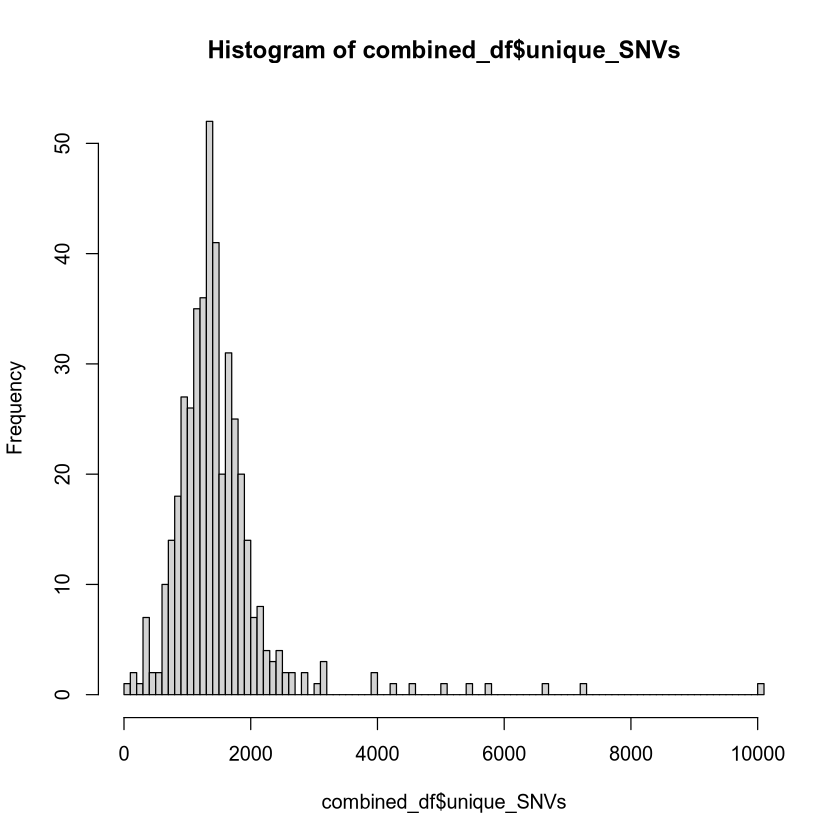

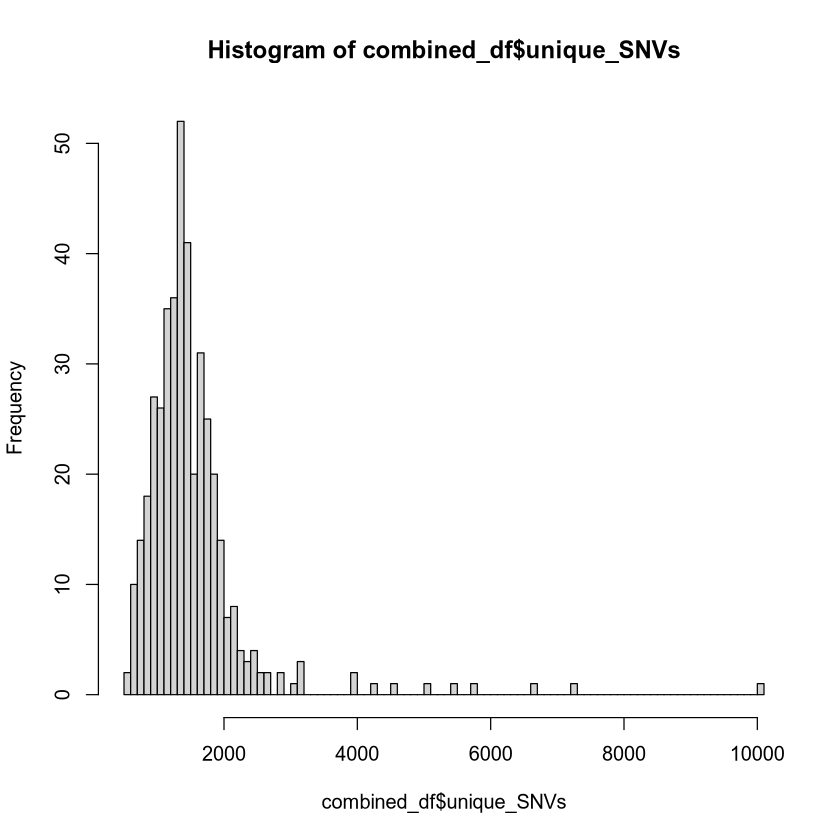

In [ ]:
load("ProcessData.RData")
library(ggplot2)
library(dplyr)
library(tidyr)
library(tidyverse)
library(sigfit)
library(ggpmisc)
library(mutspecdist)
library(patchwork)
table(combined_df$unique_SNVs < 500)
hist(combined_df$unique_SNVs, breaks = 100)

combined_df <- subset(combined_df, unique_SNVs > 500)
Hiatt <- subset(Hiatt, unique_SNVs > 500)
LeeSix <- subset(LeeSix, unique_SNVs > 500)
table(combined_df$unique_SNVs < 500)
hist(combined_df$unique_SNVs, breaks = 100)


all_cols <- names(Hiatt)
sig_prefixes <- c("^SBS", "^ID")  # prefixes for signature columns
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
sig_cols <- sig_cols[!grepl("_", sig_cols)]

region_order <- c("Right", "cecum", "asc_col", "trans_col",
                  "desc_col", "sig_col", "rectum", "Left")

amsd <- function(set1,
                set2,
                mean_or_sum = "mean",  # or "sum"
                n_sim = 1000,
                seed = NULL) {
  tol <- 1e-8
  # Validate inputs
  if (!is.matrix(set1) && !is.data.frame(set1)) stop("set1 must be a matrix or data.frame")
  if (!is.matrix(set2) && !is.data.frame(set2)) stop("set2 must be a matrix or data.frame")

  if (!mean_or_sum %in% c("mean", "sum")) {
    stop("Argument 'mean_or_sum' must be either 'mean' or 'sum'")
  }

  if (mean_or_sum == "mean" & max(c(rowSums(set1), rowSums(set2))) - 1 > tol) {
    stop("Spectra fractions should add up to 1 when running 'mean_or_sum' = 'mean'")
  }

  if (mean_or_sum == "sum" & max(c(rowSums(set1), rowSums(set2)) <= 1)) {
    stop("Run 'mean_or_sum' = 'mean' for fractional mutation spectra that add up to 1")
  }

  # Define aggregation function
  aggragate_spectra <- if (mean_or_sum == "mean") {
    function(data) colMeans(data, na.rm = TRUE)
  } else {
    function(data) colSums(data, na.rm = TRUE)
  }


  # Compute observed distance
  spectra1 <- aggragate_spectra(set1)
  spectra2 <- aggragate_spectra(set2)
  observed_distance <- cosine_dist(spectra1, spectra2)[[1]]

  # Prepare permutation dataset
  combined_set <- rbind(set1, set2)

  # Run permutations
  set.seed(seed)
  dist_rands <- numeric(n_sim)
  group_size <- nrow(set1)

  for (k in seq_len(n_sim)) {
    indices <- sample(seq_len(nrow(combined_set)), group_size)
    spectra_group1 <- aggragate_spectra(combined_set[indices, , drop = FALSE])
    spectra_group2 <- aggragate_spectra(combined_set[-indices, , drop = FALSE])
    dist_rands[k] <- cosine_dist(spectra_group1, spectra_group2)[[1]]
  }

  # Calculate p-value
  p_value <- max(c(mean(dist_rands >= observed_distance), 1 / n_sim))

  # Return output
  return(list(cosine = observed_distance, p = p_value, sims = dist_rands))
}


Figure 2: 
**Hiatt*** vs combine?


Part 1: SNV/Indel by age


In [ ]:
ggplot(Hiatt, aes(x = age, y = unique_SNVs)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = unique_SNVs, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = unique_SNVs, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt, aes(x = age, y = total_indels, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

In [ ]:
#ggplot(combined_df) + geom_jitter(aes(x=age, y=total_indels, color = cohort)) + geom_smooth(aes(x=age, y=total_indels, color = cohort))

#ggplot(combined_df) + geom_boxplot(aes(x=age, y=total_indels, color = cohort))

#ggplot(combined_df) + geom_boxplot(aes(y=(n_with_coding_snv/depth), color = cohort))


median trend by region

In [ ]:
Hiatt_donor_median <- Hiatt %>%
  group_by(age, cohort) %>%
  summarise(
    median_unique_SNVs = median(unique_SNVs, na.rm = TRUE),
    median_total_indels = median(total_indels, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(Hiatt_donor_median, aes(x = age, y = median_unique_SNVs)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

  ggplot(Hiatt_donor_median, aes(x = age, y = median_unique_SNVs, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()




In [ ]:
ggplot(Hiatt_donor_median, aes(x = age, y = median_total_indels)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt_donor_median, aes(x = age, y = median_total_indels, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()


mean

In [ ]:
Hiatt_donor_mean <- Hiatt %>%
  group_by(age, cohort) %>%
  summarise(
    mean_unique_SNVs = mean(unique_SNVs, na.rm = TRUE),
    mean_total_indels = mean(total_indels, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(Hiatt_donor_mean, aes(x = age, y = mean_unique_SNVs)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

  ggplot(Hiatt_donor_mean, aes(x = age, y = mean_unique_SNVs, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()


In [ ]:
ggplot(Hiatt_donor_mean, aes(x = age, y = mean_total_indels)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt_donor_mean, aes(x = age, y = mean_total_indels, color = cohort)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()


In [ ]:
Hiatt_donor_side_median <- Hiatt %>%
  group_by(age, cohort, side) %>%
  summarise(
    mean_unique_SNVs = mean(unique_SNVs, na.rm = TRUE),
    mean_total_indels = mean(total_indels, na.rm = TRUE),
    .groups = "drop"
  )

ggplot(Hiatt_donor_side_mean,
       aes(x = age, y = mean_unique_SNVs, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

ggplot(Hiatt_donor_side_mean,
       aes(x = age, y = mean_total_indels, color = side)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()


Part 2: Spectra + AMSD
SUBTYPES: Stacked bar of subtypes? 


In [ ]:
df <- Hiatt %>%
  mutate(
    C.T_nonCpG = `C.T` - CpG,
    C.T_CpG    = CpG
  ) %>%
  mutate(across(c(C.A, C.G, C.T_nonCpG, C.T_CpG, T.A, T.C, T.G, unique_SNVs), as.numeric))

mut_map <- tibble(
  label = c("C>A","C>G","C>T at non-CpG","C>T at CpG","T>A","T>C","T>G"),
  col   = c("C.A","C.G","C.T_nonCpG","C.T_CpG","T.A","T.C","T.G")
)

long <- df %>%
  pivot_longer(all_of(mut_map$col), names_to = "mut_col", values_to = "count") %>%
  left_join(mut_map, by = c("mut_col" = "col")) %>%
  mutate(prop = count / unique_SNVs)

# ---------------------------
# 2) Summary: mean & SE per group
# ---------------------------
summarise_group <- function(long_df, group_var = NULL) {
  if (is.null(group_var)) {
    long_df %>%
      group_by(label) %>%
      summarise(n = n_distinct(donor),
                mean_prop = mean(prop, na.rm = TRUE),
                se_prop = sd(prop, na.rm = TRUE) / sqrt(n),
                .groups = "drop") %>%
      mutate(group = "All")
  } else {
    long_df %>%
      group_by(!!sym(group_var), label) %>%
      summarise(n = n_distinct(donor),
                mean_prop = mean(prop, na.rm = TRUE),
                se_prop = sd(prop, na.rm = TRUE) / sqrt(n),
                .groups = "drop") %>%
      rename(group = !!sym(group_var))
  }
}

# ---------------------------
# 3) Plotting function: errorbars at ymin + mean_prop ± se_prop
# ---------------------------
plot_grouped_ct_stack_final <- function(summary_df,
                                        plot_title = "Plot",
                                        out_file = NULL,
                                        bar_halfwidth = 0.20,
                                        inner_gap = 0.08,
                                        cluster_pad = 0.30) {

  label_order <- mut_map$label

  # ensure label & group ordering
  summary_df <- summary_df %>%
    mutate(label = factor(label, levels = label_order),
           group = as.character(group)) %>%
    mutate(group = factor(group, levels = sort(unique(group))))

  # base_x per group
  groups <- levels(summary_df$group)
  G <- length(groups)
  base_df <- tibble(group = groups, base_x = seq_len(G))

  # slots: C>T share same slot index
  label_slots <- tibble(
    label = label_order,
    slot_index = c(1,2,3,3,4,5,6)
  )

  slot_width <- 2*bar_halfwidth + inner_gap
  max_slot <- max(label_slots$slot_index)
  slot_positions <- (label_slots$slot_index - (max_slot + 1)/2) * slot_width
  names(slot_positions) <- label_slots$label

  cluster_spacing <- max(slot_width * (max_slot + 0.1), 2*bar_halfwidth + cluster_pad)

  # compute positions
  plotdat <- summary_df %>%
    left_join(base_df, by = "group") %>%
    mutate(offset = slot_positions[as.character(label)],
           x = base_x * cluster_spacing + offset) %>%
    arrange(base_x, x, label)

  # stacking per x
  plotdat <- plotdat %>%
    group_by(group, x) %>%
    mutate(
      ymax = cumsum(mean_prop),
      ymin = lag(ymax, default = 0)
    ) %>%
    ungroup() %>%
    # compute the errorbar center and limits at ymin + mean_prop ± se_prop
    mutate(
      eb_center = ymin + mean_prop,        # top of the segment (absolute)
      eb_ymin   = eb_center - se_prop,
      eb_ymax   = eb_center + se_prop
    )

  # palette
  palette <- c(
    "C>A"="#7fb3d5","C>G"="#000000",
    "C>T at non-CpG"="#b22222","C>T at CpG"="#dca79a",
    "T>A"="#bfbfbf","T>C"="#b2d18c","T>G"="#e9cfc8"
  )

  # draw: geom_rect for bars, geom_errorbar using eb_ymin/eb_ymax
  p <- ggplot() +
    geom_rect(data = plotdat,
              aes(xmin = x - bar_halfwidth, xmax = x + bar_halfwidth,
                  ymin = ymin, ymax = ymax, fill = label),
              color = "black") +

    geom_errorbar(data = plotdat,
                  aes(x = x, ymin = eb_ymin, ymax = eb_ymax),
                  width = bar_halfwidth * 0.4, size = 0.7, color = "black") +

    scale_fill_manual(values = palette, breaks = mut_map$label) +

    scale_x_continuous(breaks = (base_df$base_x * cluster_spacing),
                       labels = base_df$group,
                       expand = expansion(add = 0.5)) +

    labs(x = NULL, y = "Relative contribution", title = plot_title, fill = NULL) +

    theme_minimal(base_size = 14) +
    theme(axis.text.x = element_text(size = 11),
          legend.position = "right",
          panel.grid.major.x = element_blank()) +

    coord_cartesian(ylim = c(0, max(plotdat$ymax) + 0.12))

  print(p)
  if (!is.null(out_file)) ggsave(out_file, p, width = max(6, G * 1.0), height = 5, dpi = 300)

  invisible(list(plot = p, plotdat = plotdat))
}

# ---------------------------
# 4) Create & save plots
# ---------------------------
overall_summary <- summarise_group(long, NULL)
plot_grouped_ct_stack_final(overall_summary, plot_title = "Overall", out_file = "plots/mutation_overall_ctstack_final2.png")

region_summary <- summarise_group(long, "region")
plot_grouped_ct_stack_final(region_summary, plot_title = "By region", out_file = "plots/mutation_by_region_ctstack_final2.png")

cohort_summary <- summarise_group(long, "cohort")
plot_grouped_ct_stack_final(cohort_summary, plot_title = "By cohort", out_file = "plots/mutation_by_cohort_ctstack_final2.png")

side_summary <- summarise_group(long, "side")
plot_grouped_ct_stack_final(side_summary, plot_title = "By side", out_file = "plots/mutation_by_side_ctstack_final2.png")

In [3]:
# Read the matrix
matrix <- read.table(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS96.all",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE,
  check.names = FALSE
)

v3.5 = read_delim("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/COSMIC_v3.5_SBS_GRCh38.txt")

convert_mutation <- function(x) {
  # Extract the left base, ref>alt, and right base
  left <- str_sub(x, 1, 1)
  middle <- str_extract(x, "(?<=\\[).+?(?=\\])")  # grabs C>A etc
  right <- str_sub(x, -1, -1)

  # Split ref>alt into two
  ref_alt <- str_split(middle, ">", simplify = TRUE)

  # Construct new notation
  paste0(left, ref_alt[1], right, ">", left, ref_alt[2], right)
}



Rows: 96 Columns: 98
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Type
dbl (97): SBS1, SBS2, SBS3, SBS4, SBS5, SBS6, SBS7a, SBS7b, SBS7c, SBS7d, SB...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Apply to dataframe
matrix <- matrix %>%
  mutate(MutationType = sapply(MutationType, convert_mutation))

v3.5 <- v3.5 %>%
  mutate(Type = sapply(Type, convert_mutation))

v3.5switched <- t(as.data.frame(v3.5[-1]))

colnames(v3.5switched) <- v3.5$Type

matrixswitched <- t(as.data.frame(matrix[-1]))

colnames(matrixswitched) <- matrix$MutationType
rownames(matrixswitched) <- gsub("X", "", rownames(matrixswitched))

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


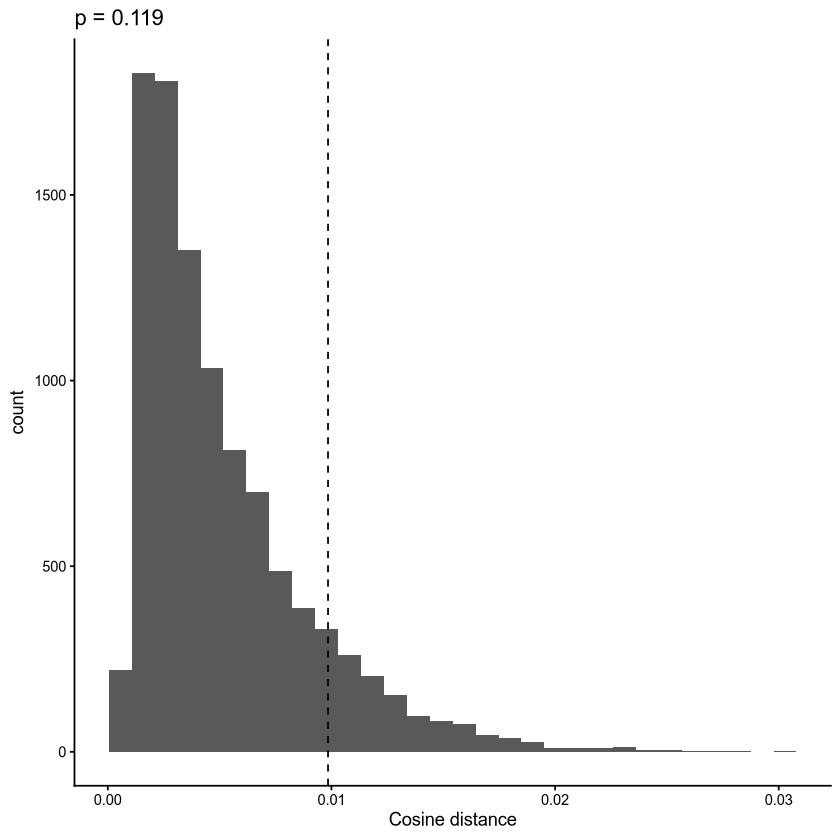

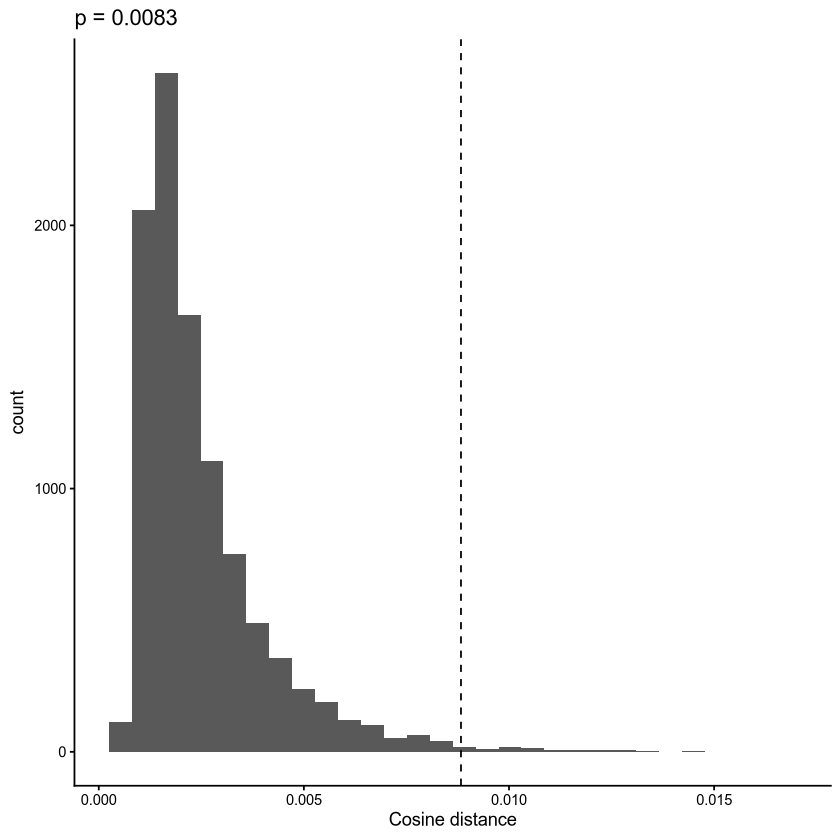

In [ ]:
Right <- subset(Hiatt, side == 'Right')
Left <- subset(Hiatt, side == "Left")

Right_list <- Right$crypt_sample
Left_list <- Left$crypt_sample

Right <- matrixswitched[rownames(matrixswitched) %in% Right_list, ]
Left <- matrixswitched[rownames(matrixswitched) %in% Left_list, ]

exp_v_con <- amsd(Right,
                  Left,
                  mean_or_sum = "sum",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)


Right <- as.data.frame(Right)/rowSums(as.data.frame(Right))
Left <- as.data.frame(Left)/rowSums(as.data.frame(Left))

#run ASMD
exp_v_con <- amsd(Right,
                  Left,
                  mean_or_sum = "mean",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)



`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


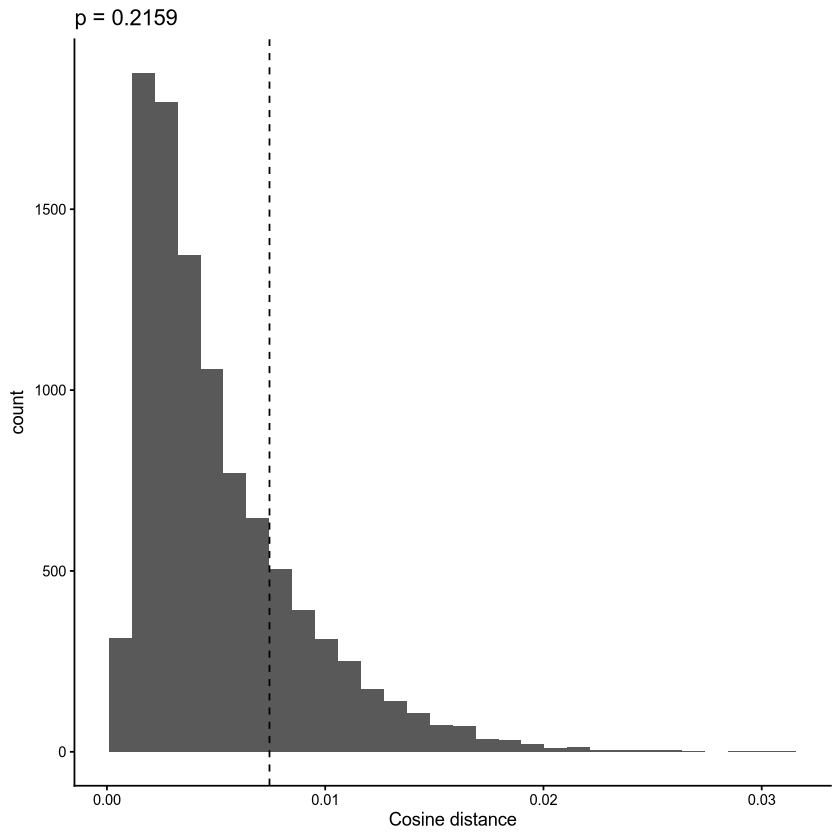

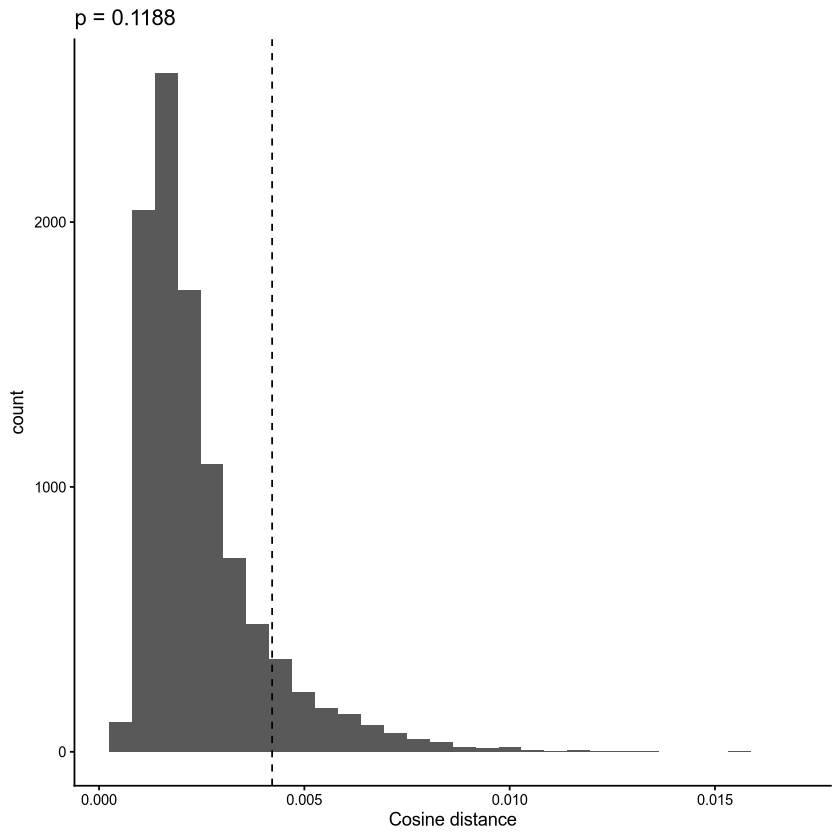

In [8]:
Right <- subset(Hiatt, cohort == 'normal')
Left <- subset(Hiatt, cohort == "adenoma")

Right_list <- Right$crypt_sample
Left_list <- Left$crypt_sample

Right <- matrixswitched[rownames(matrixswitched) %in% Right_list, ]
Left <- matrixswitched[rownames(matrixswitched) %in% Left_list, ]

exp_v_con <- amsd(Right,
                  Left,
                  mean_or_sum = "sum",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)


Right <- as.data.frame(Right)/rowSums(as.data.frame(Right))
Left <- as.data.frame(Left)/rowSums(as.data.frame(Left))

#run ASMD
exp_v_con <- amsd(Right,
                  Left,
                  mean_or_sum = "mean",
                  n_sim = 10000,
                  seed = 123)
plot_amsd_histogram(exp_v_con)


Region unique_snv count 

In [ ]:
make_clean_mutation_df <- function(df) {
  df %>%
    mutate(
      Non_CpG_CT   = C.T - CpG,
      sum_mut_types = C.A + C.G + CpG + Non_CpG_CT + T.A + T.C + T.G,
      diff = sum_mut_types - unique_SNVs
    ) %>%
    arrange(region, desc(sum_mut_types)) %>%   # sort within region
    group_by(region) %>%
    mutate(
      region_rank = row_number()
    ) %>%
    ungroup()
}

Hiatt2 <- make_clean_mutation_df(Hiatt)

ggplot(Hiatt2, aes(x = region_rank, y = unique_SNVs)) +
  geom_col() +
  facet_grid(~ region, scales = "free_x", space = "free_x") +
  theme_bw() +
  theme(
    strip.background = element_rect(fill = "grey90"),
    strip.text = element_text(face = "bold")
  ) + ylim(0,6000)



In [ ]:
make_clean_mutation_df <- function(df) {
  df %>%
    mutate(
      sum_indel = total_indels,
    ) %>%
    arrange(region, desc(sum_indel)) %>%   # sort within region
    group_by(region) %>%
    mutate(
      region_rank = row_number()
    ) %>%
    ungroup()
}

Hiatt2 <- make_clean_mutation_df(Hiatt)

ggplot(Hiatt2, aes(x = region_rank, y = total_indels)) +
  geom_col() +
  facet_grid(~ region, scales = "free_x", space = "free_x") +
  theme_bw() +
  theme(
    strip.background = element_rect(fill = "grey90"),
    strip.text = element_text(face = "bold")
  ) + ylim(0,200)



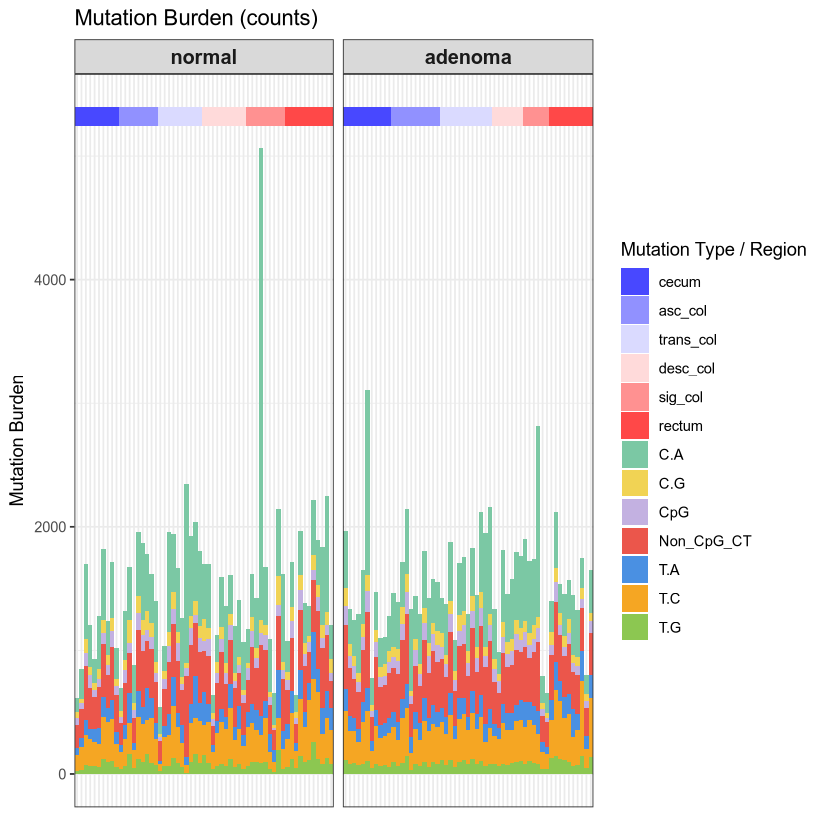

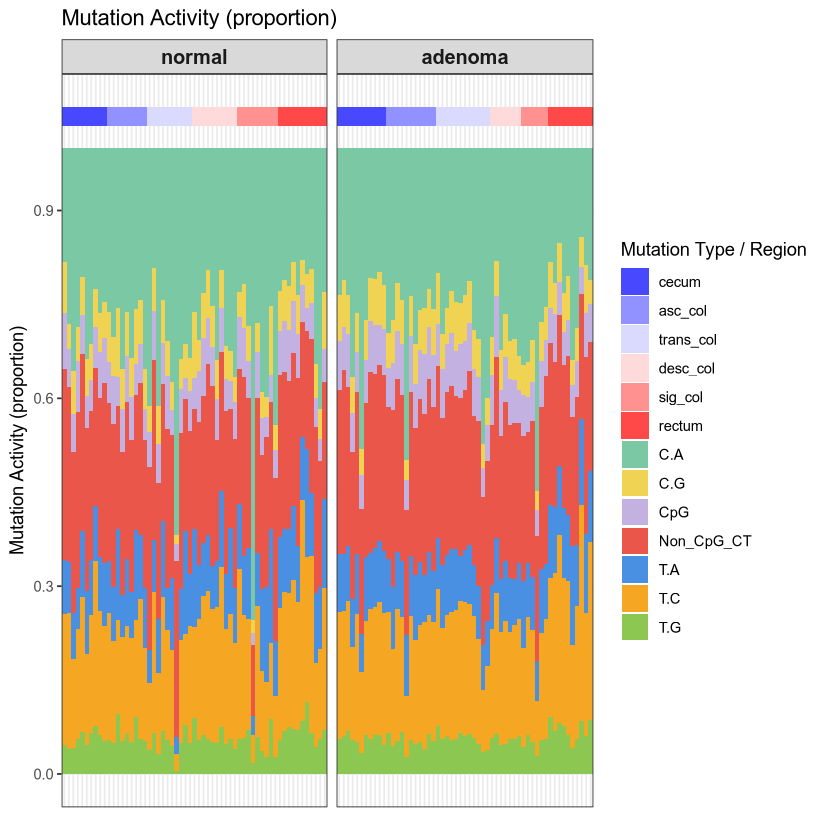

In [15]:
make_mutation_burden_and_activity <- function(df, region_order) {

  # --- Define mutation types ---
  df <- df %>%
    mutate(
      Non_CpG_CT = C.T - CpG,
      total_SNVs = C.A + C.G + CpG + Non_CpG_CT + T.A + T.C + T.G,
      region = factor(region, levels = region_order)
    )

  mut_types <- c("C.A","C.G","CpG","Non_CpG_CT","T.A","T.C","T.G")

  # --- Sort samples by region ---
  df <- df %>%
    arrange(region, cohort, crypt_sample) %>%
    mutate(xid = paste(cohort, region, crypt_sample, sep = "_"),
           xid = factor(xid, levels = unique(xid)))

  # --- Long format ---
  df_long <- df %>%
    select(crypt_sample, region, cohort, all_of(mut_types), total_SNVs, xid) %>%
    pivot_longer(
      cols = all_of(mut_types),
      names_to = "mut_type",
      values_to = "count"
    ) %>%
    mutate(prop = count / total_SNVs)

  # --- Colors ---
  mut_colors <- c(
    "C.A"        = "#7BC8A4",
    "C.G"        = "#F1D354",
    "CpG"        = "#C3B1E1",
    "Non_CpG_CT" = "#EB564B",
    "T.A"        = "#4A90E2",
    "T.C"        = "#F5A623",
    "T.G"        = "#8CC751"
  )

  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  # --- Region strip: one tile per crypt_sample with region color ---
  df_region_strip <- df %>%
    mutate(y = 1.05,  # above proportion bars
           y_count = max(df_long$total_SNVs) + max(df_long$total_SNVs)*0.05)  # above count bars

  # ===========================================================
  # PANEL B — Mutation Burden
  # ===========================================================
  max_count <- max(df_long$total_SNVs)

  p_burden <- ggplot() +
    geom_col(data = df_long, aes(x = xid, y = count, fill = mut_type), width = 1) +
    geom_tile(data = df_region_strip,
              aes(x = xid, y = y_count, fill = region),
              width = 1, height = max_count*0.03) +
    scale_fill_manual(values = c(mut_colors, region_colors), name = "Mutation Type / Region") +
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x  = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text   = element_text(size = 12, face = "bold")
    ) +
    ylab("Mutation Burden") +
    xlab("") +
    ggtitle("Mutation Burden (counts)")

  # ===========================================================
  # PANEL C — Mutation Activity
  # ===========================================================
  p_activity <- ggplot() +
    geom_col(data = df_long, aes(x = xid, y = prop, fill = mut_type), width = 1) +
    geom_tile(data = df_region_strip,
              aes(x = xid, y = y, fill = region),
              width = 1, height = 0.03) +
    scale_fill_manual(values = c(mut_colors, region_colors), name = "Mutation Type / Region") +
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x  = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text   = element_text(size = 12, face = "bold")
    ) +
    ylab("Mutation Activity (proportion)") +
    xlab("") +
    ggtitle("Mutation Activity (proportion)")

  return(list(burden = p_burden, activity = p_activity))
}

plots <- make_mutation_burden_and_activity(Hiatt, region_order)
p_burden   <- plots$burden
p_activity <- plots$activity

p_burden
p_activity


Part 3: MSI

Driver gene nonsense

In [ ]:
instability = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/mutations/instability/instability.tsv',
                       stringsAsFactors = FALSE, header = TRUE, sep = "\t")

#colnames(instability)[1] <- "crypt_sample"

#combined_instability <- merge(sample_summary, combined_df, by = "crypt_sample")

#ggplot(df_long, aes(x=value)) + geom_histogram() + xlim(0,5)

mean_threshold <- 2.2569
median_threshold <- 3

# Function to split value and haplogroup
split_value_hap <- function(x) {
  tibble(
    value = as.numeric(str_extract(x, "^[0-9.]+")),
    haplogroup = as.integer(str_extract(x, "(?<=\\()\\d+(?=\\))"))
  )
}

# Convert to long format and parse
df_long <- instability %>%
  pivot_longer(-Sample, names_to = "locus_measure", values_to = "raw") %>%
  rowwise() %>%
  mutate(
    value = split_value_hap(raw)$value,
    haplogroup = split_value_hap(raw)$haplogroup,
    measure = ifelse(str_detect(locus_measure, "mean_ad"), "mean", "median"),
    locus = str_extract(locus_measure, "X[0-9.]+\\.[TA]")
  ) %>%
  select(-raw)

# Determine if value exceeds threshold
df_long <- df_long %>%
  mutate(
    instable_mean   = ifelse(measure == "mean", value > mean_threshold, NA),
    instable_median = ifelse(measure == "median", value > median_threshold, NA)
  )

#instability_mean <- subset(df_long_hiatt, measure == "mean")
#mean_values <- instability_mean$value
#instability_median <- subset(df_long_hiatt, measure == "median")
#median_values <- instability_median$value

#mean_threshold <- quantile(mean_values, 0.95, na.rm = TRUE)   # 95th percentile
#median_threshold <- quantile(median_values, 0.95, na.rm = TRUE)
#mean_threshold: 2.2569
#median_threshold: 3

# Plot instability for mean only
ggplot(df_long %>% filter(measure == "mean"), aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  geom_vline(xintercept = mean_threshold, color = "red", linetype = "dashed") +
  labs(title = "Mean values with instability threshold") + xlim(0,10)

# Plot instability for median only
ggplot(df_long %>% filter(measure == "median"), aes(x = value)) +
  geom_histogram(bins = 30, fill = "darkgreen") +
  geom_vline(xintercept = median_threshold, color = "red", linetype = "dashed") +
  labs(title = "Median values with instability threshold") + xlim(0,10)

# Aggregate per locus: mean and median must both be instable for haplogroup
locus_summary <- df_long %>%
  group_by(Sample, locus, haplogroup) %>%
  summarise(
    haplo_instable = all(c(
      instable_mean[measure == "mean"],
      instable_median[measure == "median"]
    )),
    .groups = "drop"
  ) %>%
  group_by(Sample, locus) %>%
  summarise(
    locus_instable = any(haplo_instable),
    .groups = "drop"
  )

# Aggregate per sample
sample_summary <- locus_summary %>%
  group_by(Sample) %>%
  summarise(
    n_instable_loci = sum(locus_instable),
    MSI_status = case_when(
      n_instable_loci == 0 ~ "MSS",
      n_instable_loci %in% 1:2 ~ "MSI-L",
      n_instable_loci >= 3 ~ "MSI-H"
    )
  )

# Output
sample_summary

colnames(sample_summary)[1] <- "crypt_sample"

combined_instability <- merge(sample_summary, combined_df, by = "crypt_sample")

combined_instability<- subset(combined_instability, study == "Hiatt")

# combined_instability<- subset(combined_instability, study == "LeeSix")

# Function to plot MSI distribution by a given factor
plot_MSI_by_factor <- function(data, factor_col) {

  plot_data <- data %>%
    group_by(!!sym(factor_col), MSI_status) %>%
    summarise(n = n(), .groups = "drop") %>%
    group_by(!!sym(factor_col)) %>%
    mutate(freq = n / sum(n))

  p <- ggplot(plot_data, aes(x = !!sym(factor_col), y = freq, fill = MSI_status)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(x = factor_col, y = "Percentage", fill = "MSI Status",
         title = paste("MSI Distribution by", factor_col)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  return(p)
}

# Automatically detect factor columns (excluding Sample and MSI_status)
factor_cols <- combined_instability %>%
  select(-crypt_sample, -MSI_status) %>%
  select(where(~ is.factor(.) || is.character(.))) %>%
  names()

# Create a list of plots
plots <- lapply(factor_cols, function(f) plot_MSI_by_factor(combined_instability, f))

# Optionally: print all plots in a loop
for (p in plots) {
  print(p)
}




In [ ]:
ggplot(combined_instability, aes(x = MSI_status, y = ID18)) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE) +
  stat_poly_eq(
    aes(label = after_stat(paste(eq.label, rr.label, p.value.label, sep = "\n"))),
    formula = y ~ x,
    parse = TRUE
  ) +
  theme_minimal()

Part 4: Signatures 
MAKE THE LEE-SIX SUPP FIGURE THAT STARTED IT ALL
Signatures present in samples? We’ll think about it
Stacked bar signatures




'SBS1' Spontaneous deamination
'SBS5' Clocklike
'SBS18' oxidative 
'SBS22a' Aristocholic acid
'SBS23' Unknown
'SBS25' Chemotherapy tx
'SBS30' NTHL1
'SBS36' MUTYH
'SBS40a' Flat unknown 
'SBS45' Artefact
'SBS88' Colibactin
'SBS89' Unknown (early life)
'SBS95' Artefact 
'ID1' Slippage
'ID2' Slippage
'ID3' Tobacco
'ID4' Unknown
'ID7' Defective mismatch repair
'ID9' Unknown
'ID18' Colibactin
'ID23' Artistocholic exposure 


In [ ]:
cor_method <- "spearman"                  # "pearson" or "spearman"
alpha <- 0.05                              # significance cutoff (FDR-adjusted)

df_raw <- Hiatt
# ---------- LOAD DATA ----------
# find signature columns
all_cols <- names(df_raw)
sig_cols <- all_cols[Reduce(`|`, lapply(sig_prefixes, function(p) grepl(p, all_cols)))]
sig_cols <- sig_cols[!grepl("_", sig_cols)]

sig_cols

if (length(sig_cols) < 2) stop("Not enough signature columns found.")

# convert signature columns to numeric
df_sig <- df_raw %>%
  mutate(across(all_of(sig_cols), ~ suppressWarnings(as.numeric(.)))) %>%
  select(all_of(sig_cols))

# remove signatures with nearly all NA or zero variance
valid_sig <- sig_cols[
  sapply(df_sig, function(x) sum(!is.na(x)) > 3 && sd(x, na.rm=TRUE) > 0)
]
df_sig <- df_sig %>% select(all_of(valid_sig))

# ---------- PAIRWISE CORRELATIONS ----------
pairs <- expand.grid(sig1 = valid_sig, sig2 = valid_sig, stringsAsFactors = FALSE) %>%
  filter(sig1 < sig2)  # avoid duplicates and diagonal

cor_results <- map_dfr(1:nrow(pairs), function(i) {
  s1 <- pairs$sig1[i]
  s2 <- pairs$sig2[i]

  v1 <- df_sig[[s1]]
  v2 <- df_sig[[s2]]

  # remove missing values
  df_tmp <- tibble(v1 = v1, v2 = v2) %>% drop_na()

  if (nrow(df_tmp) < 4) {
    return(tibble(sig1=s1, sig2=s2, cor=NA_real_, p=NA_real_))
  }

  ct <- suppressWarnings(cor.test(df_tmp$v1, df_tmp$v2, method = cor_method))

  tibble(
    sig1 = s1,
    sig2 = s2,
    cor  = unname(ct$estimate),
    p    = ct$p.value
  )
})

# ---------- MULTIPLE TEST CORRECTION ----------
cor_results <- cor_results %>%
  mutate(p_adj = p.adjust(p, method = "fdr")) %>%
  mutate(significant = p_adj < alpha)

# show table of significant correlations
# ---------- PLOT SIGNIFICANT CORRELATIONS (only if p_adj < alpha) ----------
sig_table <- cor_results %>% filter(!is.na(p_adj) & p_adj < alpha) %>% arrange(p_adj)

message("\nNumber of significant correlations (FDR < ", alpha, "): ", nrow(sig_table), "\n")

if (nrow(sig_table) == 0) {
  message("No significant signature–signature correlations at FDR = ", alpha,
          ". Nothing will be plotted. Consider increasing alpha or using raw p-values for exploration.")
} else {
  # loop only over significant pairs
  for (i in seq_len(nrow(sig_table))) {
    s1 <- sig_table$sig1[i]
    s2 <- sig_table$sig2[i]
    r  <- round(sig_table$cor[i], 3)
    p_raw  <- signif(sig_table$p[i], 3)
    p_adj  <- signif(sig_table$p_adj[i], 3)

    df_tmp <- tibble(
      x = df_sig[[s1]],
      y = df_sig[[s2]]
    ) %>% drop_na()

    p <- ggplot(df_tmp, aes(x = x, y = y)) +
      geom_point(alpha = 0.6, color = "steelblue", size = 2) +
      geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.5) +
      labs(
        title = paste0(s1, " vs ", s2),
        subtitle = paste0("ρ = ", r, "   p = ", p_adj, "   FDR = ", p_adj),
        x = s1,
        y = s2
      ) +
      theme_bw(base_size = 12)

    print(p)
  }
}


# A tibble: 2 × 3
  cohort  n_rows n_distinct_age
  <fct>    <int>          <int>
1 normal       9              9
2 adenoma      9              9


---- processing signature: ID9 ----

`geom_smooth()` using formula = 'y ~ x'


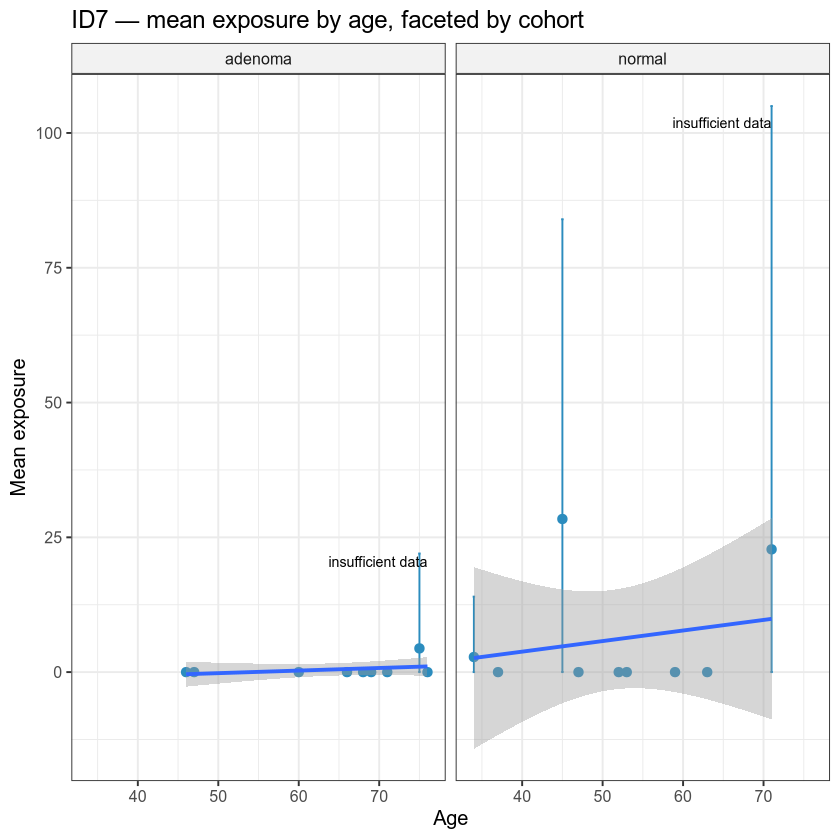

`geom_smooth()` using formula = 'y ~ x'


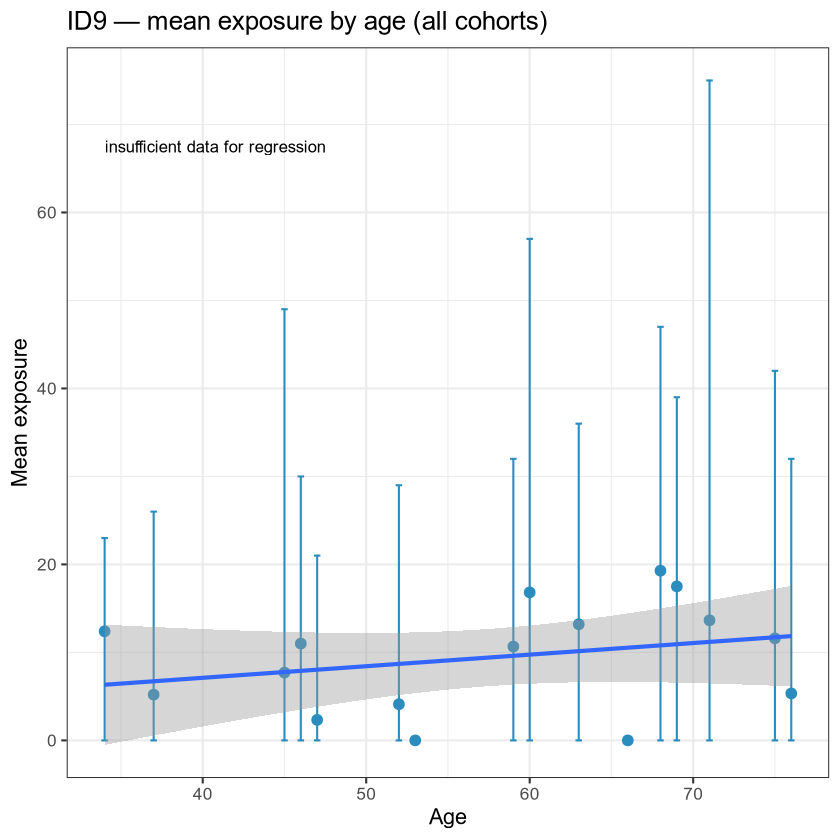

  debug: cohort counts and distinct ages:



# A tibble: 2 × 3
  cohort  n_rows n_distinct_age
  <fct>    <int>          <int>
1 normal       9              9
2 adenoma      9              9


---- processing signature: ID18 ----

`geom_smooth()` using formula = 'y ~ x'


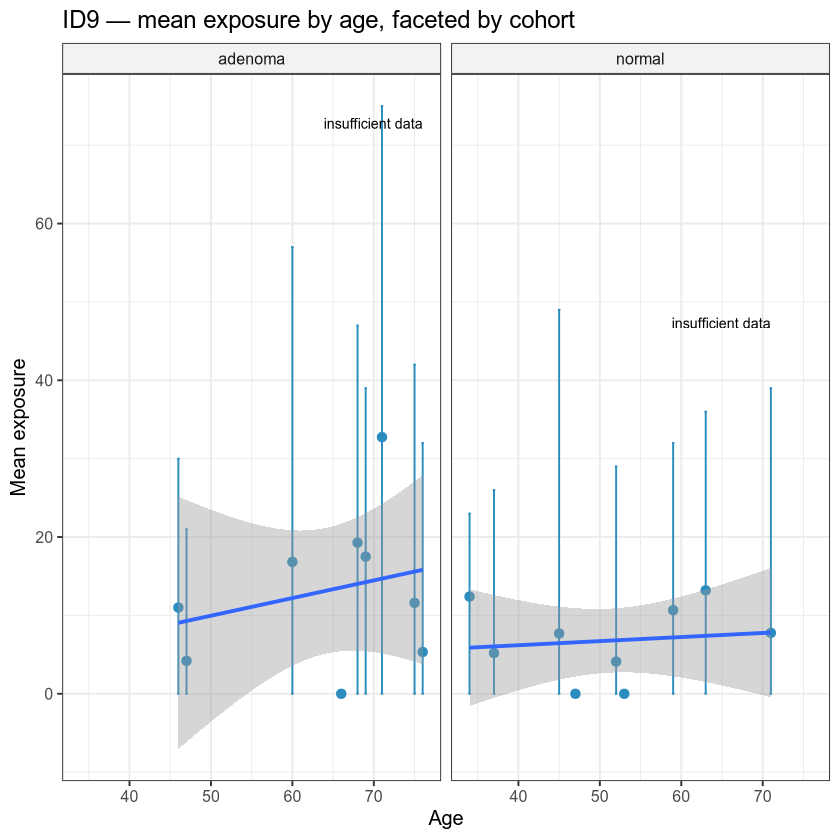

`geom_smooth()` using formula = 'y ~ x'


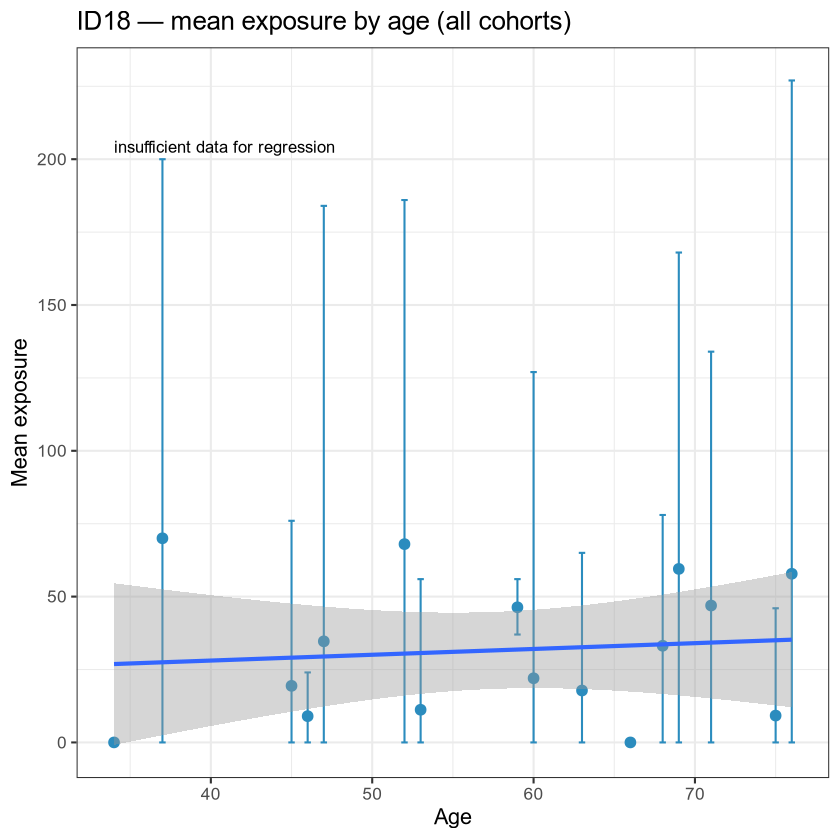

  debug: cohort counts and distinct ages:



# A tibble: 2 × 3
  cohort  n_rows n_distinct_age
  <fct>    <int>          <int>
1 normal       9              9
2 adenoma      9              9


---- processing signature: ID23 ----

`geom_smooth()` using formula = 'y ~ x'


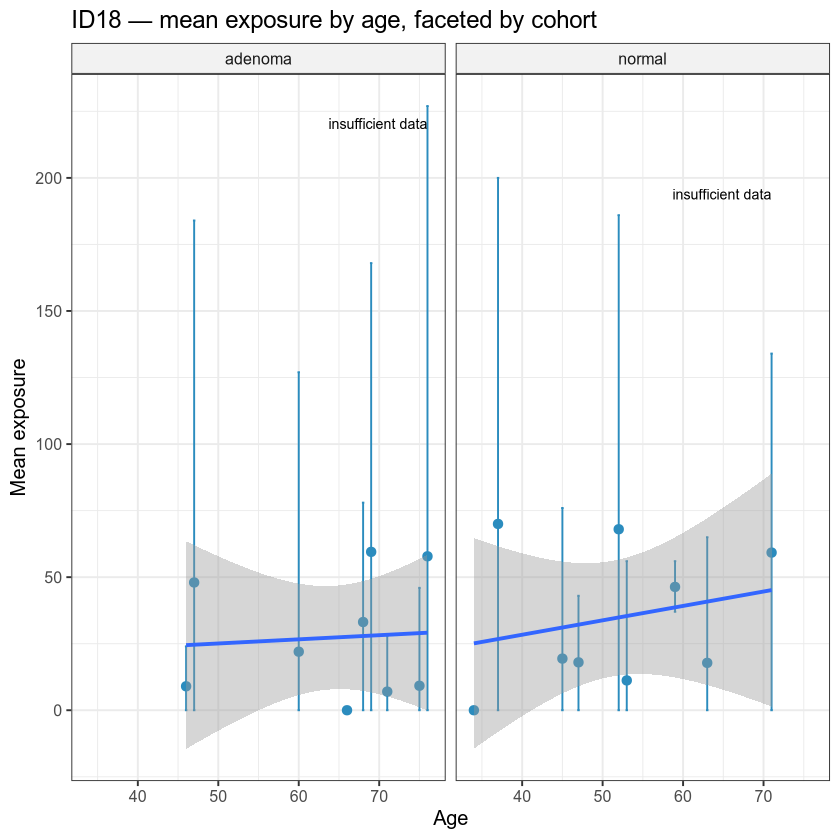

`geom_smooth()` using formula = 'y ~ x'


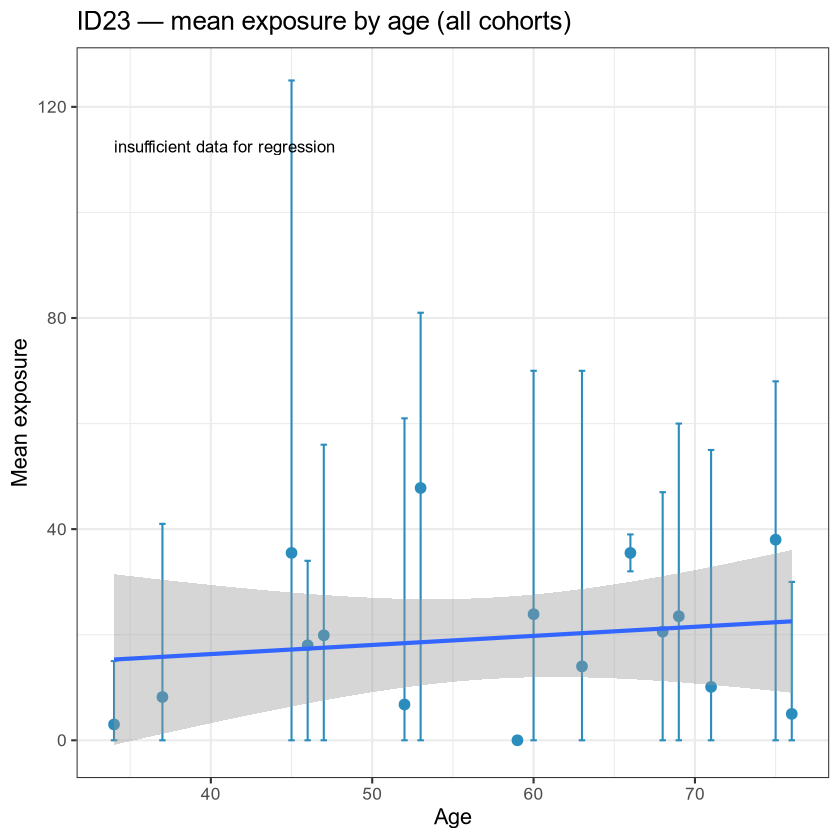

  debug: cohort counts and distinct ages:



# A tibble: 2 × 3
  cohort  n_rows n_distinct_age
  <fct>    <int>          <int>
1 normal       9              9
2 adenoma      9              9


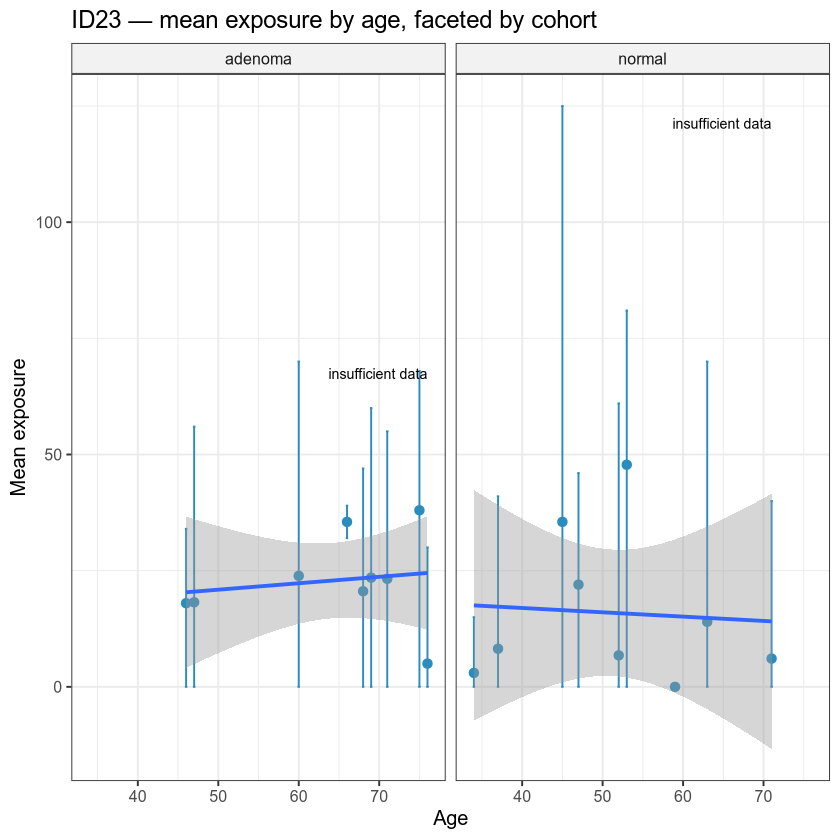

In [6]:
### Signature by age (maybe separate clocklike from early life (SBS89))

# choose minimum distinct-x rows required to attempt a smoothing/regression
min_points_for_smooth <- 2

# safe helper: return age_z term tidy row or NULL
safe_age_lm <- possibly(function(df) {
  df2 <- df %>%
    filter(!is.na(Mean), !is.na(age)) %>%
    mutate(
      Mean_z = as.numeric(scale(Mean)),
      age_num = as.numeric(age),
      age_z = as.numeric(scale(age_num))
    )
  # require >1 distinct ages and at least 3 rows (tunable)
  if (n_distinct(df2$age_num) < 2 || nrow(df2) < 3) return(NULL)
  fit <- lm(Mean_z ~ age_z, data = df2)
  tidy(fit) %>% filter(term == "age_z")
}, otherwise = NULL)

# iterate signatures
for (sig in sig_cols) {
  message("---- processing signature: ", sig, " ----")

  df <- Hiatt %>%
    select(cohort, age, all_of(sig)) %>%
    rename(exposure = !!sig) %>%
    mutate(age = as.numeric(age))  # coerce to numeric; NAs may be introduced if not numeric

  # skip if nothing to plot
  if (nrow(df) == 0 || all(is.na(df$exposure))) {
    message("  skipping ", sig, ": no non-NA exposures found.")
    next
  }

  # pooled-by-age summary (group by exact age)
  summ_age <- df %>%
    group_by(age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # skip if no valid summary
  if (nrow(summ_age) == 0 || all(is.na(summ_age$Mean))) {
    message("  skipping ", sig, ": no valid mean values after aggregation.")
    next
  }

  # overall regression (pooled across cohorts) on Mean ~ age
  reg_overall <- safe_age_lm(summ_age)
  if (!is.null(reg_overall)) {
    reg_overall <- reg_overall %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  } else {
    reg_overall <- tibble(label = "insufficient data")
  }

  # Plot A: pooled by age (conditionally add smooth only when enough points)
  p_age <- ggplot(summ_age, aes(x = age, y = Mean)) +
    geom_point(size = 2.5, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.4, color = "#2b8cbe") +
    theme_bw(base_size = 13) +
    labs(title = paste0(sig, " — mean exposure by age (all cohorts)"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5))

  # add smooth if enough distinct age rows exist
  if (nrow(summ_age) >= min_points_for_smooth && n_distinct(summ_age$age[!is.na(summ_age$Mean)]) >= 2) {
    p_age <- p_age + geom_smooth(method = "lm", se = TRUE)
  } else {
    message("  pooled: not enough distinct age points for smoothing (skipping geom_smooth).")
  }

  # annotate overall label if available
  if (!is.null(reg_overall$label) && reg_overall$label != "insufficient data") {
    x_pos <- max(summ_age$age, na.rm = TRUE)
    y_top <- max(summ_age$Maximum, na.rm = TRUE)
    # noise-safe placement when y_top is -Inf/NA
    if (is.finite(y_top) && is.finite(x_pos)) {
      p_age <- p_age +
        annotate("text", x = x_pos, y = y_top * 0.98,
                 label = reg_overall$label, hjust = 1, vjust = 1, size = 3.5)
    }
  } else {
    # place fallback label at left, only if finite values exist
    if (is.finite(max(summ_age$Maximum, na.rm = TRUE))) {
      p_age <- p_age +
        annotate("text", x = min(summ_age$age, na.rm = TRUE),
                 y = max(summ_age$Maximum, na.rm = TRUE) * 0.9,
                 label = "insufficient data for regression", size = 3.5, hjust = 0)
    }
  }

  print(p_age)

  # per-cohort summaries
  summ_age_cohort <- df %>%
    group_by(cohort, age) %>%
    summarise(
      Mean = mean(exposure, na.rm = TRUE),
      Median = median(exposure, na.rm = TRUE),
      Minimum = min(exposure, na.rm = TRUE),
      Maximum = max(exposure, na.rm = TRUE),
      SD = sd(exposure, na.rm = TRUE),
      IQR = IQR(exposure, na.rm = TRUE),
      n = sum(!is.na(exposure)),
      .groups = "drop"
    ) %>%
    filter(!is.na(age))

  # compute per-cohort regression stats safely
  per_cohort_models <- summ_age_cohort %>%
    group_by(cohort) %>%
    nest() %>%
    mutate(tidy = map(data, safe_age_lm))

  # extract tidy results where not NULL
  reg_by_cohort <- per_cohort_models %>%
    filter(!map_lgl(tidy, is.null)) %>%
    transmute(cohort, tidy = map(tidy, as_tibble)) %>%
    unnest(cols = tidy)

  # If reg_by_cohort is empty, create an empty-safe tibble with expected columns
  if (nrow(reg_by_cohort) == 0) {
    reg_by_cohort <- tibble(
      cohort = character(),
      estimate = numeric(),
      std.error = numeric(),
      statistic = numeric(),
      p.value = numeric(),
      p_bonf = numeric(),
      label = character()
    )
  } else {
    reg_by_cohort <- reg_by_cohort %>%
      mutate(p_bonf = p.adjust(p.value, method = "bonferroni"),
             label = paste0("β=", signif(estimate, 3), "\n p=", signif(p.value, 3)))
  }

  # prepare label_df that includes every cohort (fallback to insufficient data)
  cohort_ymax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(ymax = max(Maximum, na.rm = TRUE), .groups = "drop")

  cohort_xmax <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(xmax = max(age, na.rm = TRUE), .groups = "drop")

  label_df <- cohort_ymax %>%
    left_join(cohort_xmax, by = "cohort") %>%
    left_join(reg_by_cohort %>% select(cohort, label), by = "cohort") %>%
    mutate(
      label = ifelse(is.na(label) | label == "", "insufficient data", label),
      x = xmax,
      y = ifelse(!is.finite(ymax), NA, ymax * 0.98)
    )

  # decide which cohorts have enough distinct age points for smoothing
  smooth_ok_cohorts <- summ_age_cohort %>%
    group_by(cohort) %>%
    summarise(n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop") %>%
    filter(n_distinct_age >= min_points_for_smooth) %>%
    pull(cohort)

  if (length(smooth_ok_cohorts) == 0) {
    message("  per-cohort: no cohorts with >= ", min_points_for_smooth, " distinct age points -> skipping per-cohort geom_smooth.")
  }

  # Plot B: faceted by cohort with per-cohort stats
  p_age_cohort <- ggplot(summ_age_cohort, aes(x = age, y = Mean)) +
    geom_point(size = 2.2, color = "#2b8cbe") +
    geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                  width = 0.3, color = "#2b8cbe") +
    facet_wrap(~ cohort, ncol = 2, scales = "fixed") +
    theme_bw(base_size = 12) +
    labs(title = paste0(sig, " — mean exposure by age, faceted by cohort"),
         x = "Age", y = "Mean exposure") +
    theme(axis.text.x = element_text(angle = 0, hjust = 0.5),
          strip.background = element_rect(fill = "grey95"))

  # add smoothing only for cohorts that have enough distinct ages
  if (length(smooth_ok_cohorts) > 0) {
    p_age_cohort <- p_age_cohort +
      geom_smooth(
        data = summ_age_cohort %>% filter(cohort %in% smooth_ok_cohorts),
        method = "lm",
        se = TRUE,
        inherit.aes = TRUE
      )
  }

  # add labels (insufficient-data labels will appear where y is finite)
  p_age_cohort <- p_age_cohort +
    geom_text(data = label_df, aes(x = x, y = y, label = label),
              inherit.aes = FALSE, hjust = 1, vjust = 1, size = 3, na.rm = TRUE)

  print(p_age_cohort)

  # optional debug summary printed to console to inspect cohorts
  message("  debug: cohort counts and distinct ages:")
  print(
    summ_age_cohort %>%
      group_by(cohort) %>%
      summarise(n_rows = n(), n_distinct_age = n_distinct(age[!is.na(Mean)]), .groups = "drop")
  )
}


After age signature

In [ ]:
make_stacked_plot_cosmic_gradient <- function(df, sig_cols, title, region_order) {

  ## ---- derive signature groups ----

  SBS_cols <- sig_cols[grepl("^SBS", sig_cols)]
  ID_cols  <- sig_cols[grepl("^ID",  sig_cols)]

  ## ---- 1. Prepare long format ----
  df_long <- df %>%
    select(crypt_sample, region, cohort, all_of(sig_cols)) %>%
    pivot_longer(
      cols = all_of(sig_cols),
      names_to = "signature",
      values_to = "value"
    ) %>%
    group_by(crypt_sample) %>%
    mutate(
      total = sum(value, na.rm = TRUE),
      prop  = ifelse(total == 0, 0, value / total)
    ) %>%
    ungroup() %>%
    mutate(region = factor(region, levels = region_order)) %>%
    arrange(cohort, region) %>%
    mutate(xid = paste(cohort, region, crypt_sample, sep = "_"))

  df_long$xid <- factor(df_long$xid, levels = unique(df_long$xid))

  ## ---- 2. Region strip (gradient) ----
  region_strip <- df_long %>%
    select(xid, region, cohort) %>%
    distinct() %>%
    mutate(ymin = 1.02, ymax = 1.05)

  ## ---- 3. Signature colors (SBS + ID separately) ----
  sig_colors <- c()

  if (length(SBS_cols) > 0) {
    sig_colors <- c(
      sig_colors,
      setNames(
        colorRampPalette(c("#2166ac", "#67a9cf", "#d1e5f0"))(length(SBS_cols)),
        SBS_cols
      )
    )
  }

  if (length(ID_cols) > 0) {
    sig_colors <- c(
      sig_colors,
      setNames(
        colorRampPalette(c("#b2182b", "#ef8a62", "#fddbc7"))(length(ID_cols)),
        ID_cols
      )
    )
  }

  ## ---- 4. Region gradient colors ----
  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  ## ---- 5. Plot ----
  p <- ggplot() +
    geom_col(
      data = df_long,
      aes(x = xid, y = prop, fill = signature),
      width = 1
    ) +
    scale_fill_manual(
      values = sig_colors,
      name = "Signature",
      guide = guide_legend(ncol = 2)
    ) +
    ggnewscale::new_scale_fill() +
    geom_tile(
      data = region_strip,
      aes(x = xid, y = (ymin + ymax) / 2, fill = region),
      height = 0.03
    ) +
    scale_fill_manual(values = region_colors, name = "Region") +
    facet_grid(~ cohort, scales = "free_x", space = "free_x") +
    theme_bw() +
    theme(
      axis.text.x  = element_blank(),
      axis.ticks.x = element_blank(),
      strip.text   = element_text(size = 12, face = "bold")
    ) +
    ylab("Proportion of signature contribution") +
    xlab("Samples (grouped by region inside cohort)") +
    ggtitle(title)

  return(p)

}


Signature waterfall

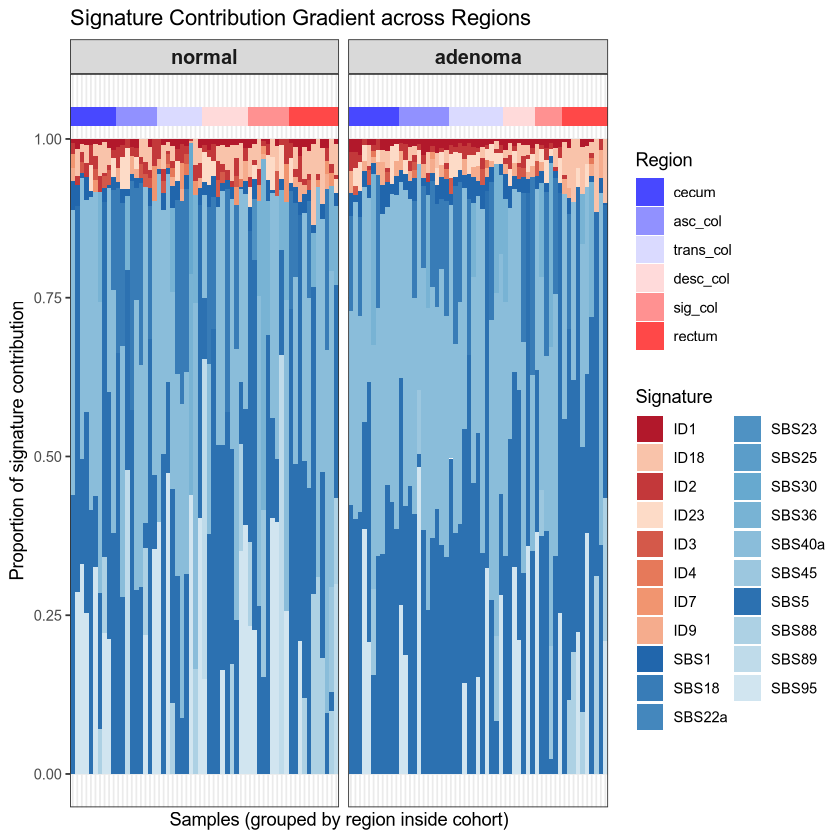

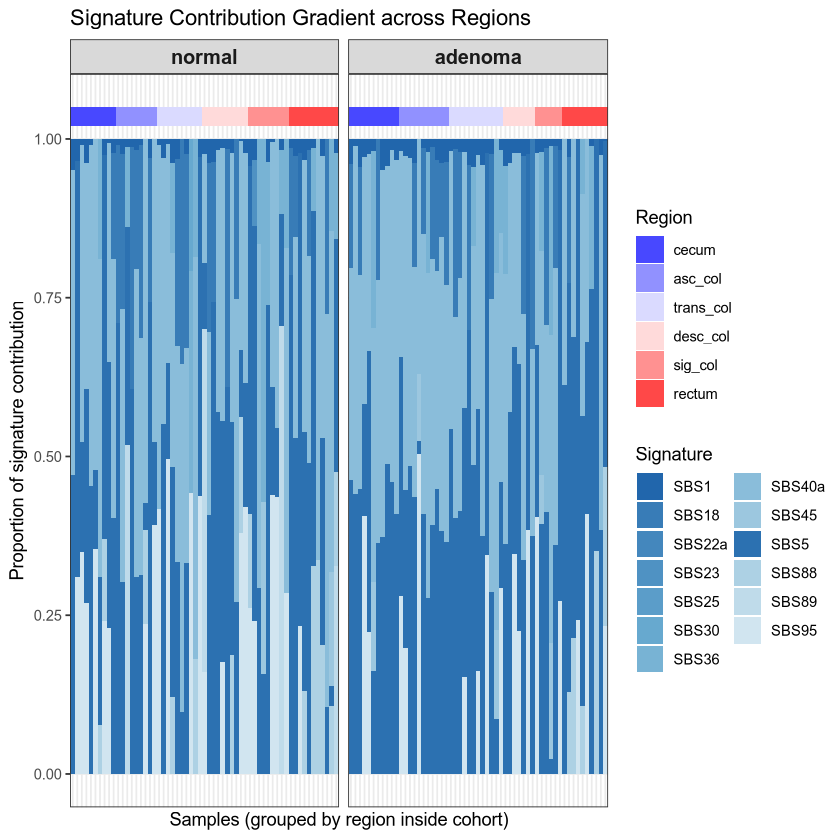

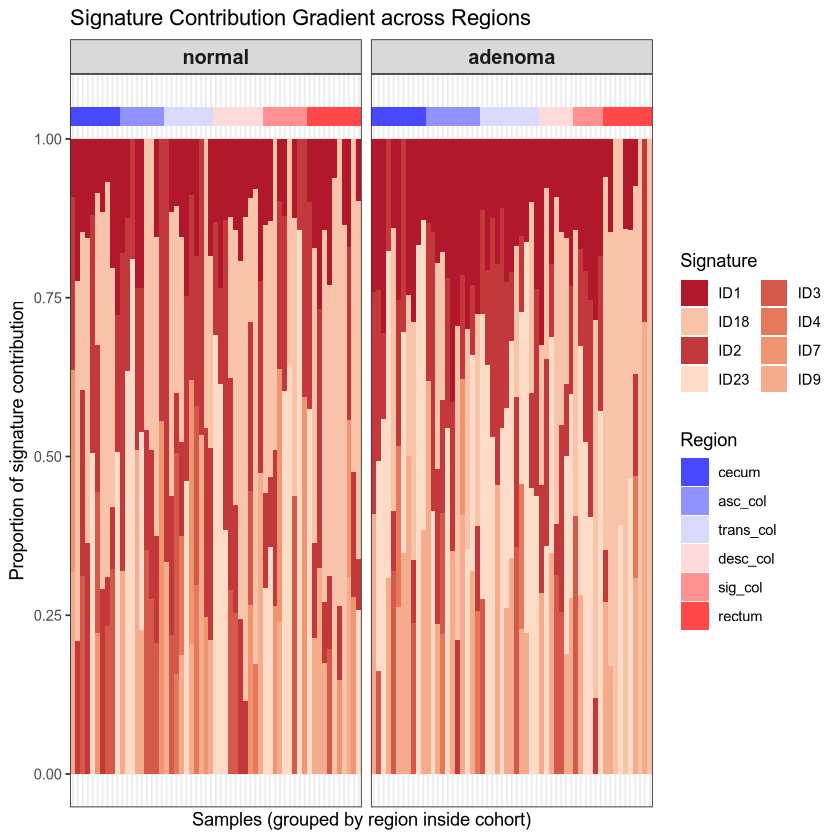

In [22]:
title <- "Signature Contribution Gradient across Regions"
SBS_cols <- sig_cols[grepl("^SBS", sig_cols)]
ID_cols  <- sig_cols[grepl("^ID",  sig_cols)]
p <- make_stacked_plot_cosmic_gradient(Hiatt, sig_cols, title, region_order)
print(p)
make_stacked_plot_cosmic_gradient(Hiatt, SBS_cols, title, region_order)
make_stacked_plot_cosmic_gradient(Hiatt, ID_cols, title, region_order)



Signatures as regional value and proportion

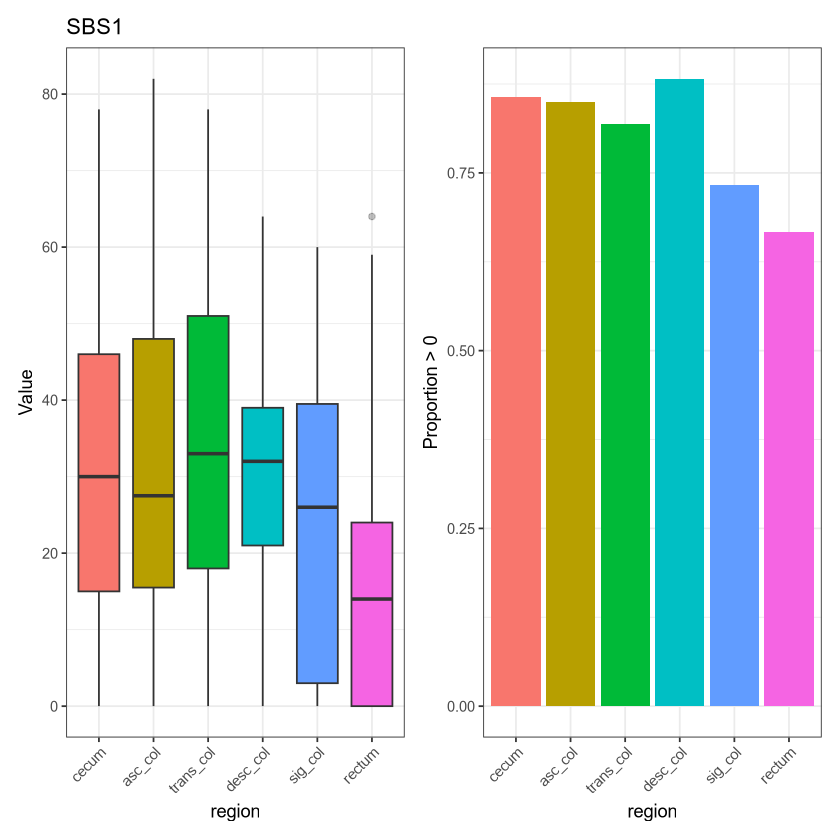

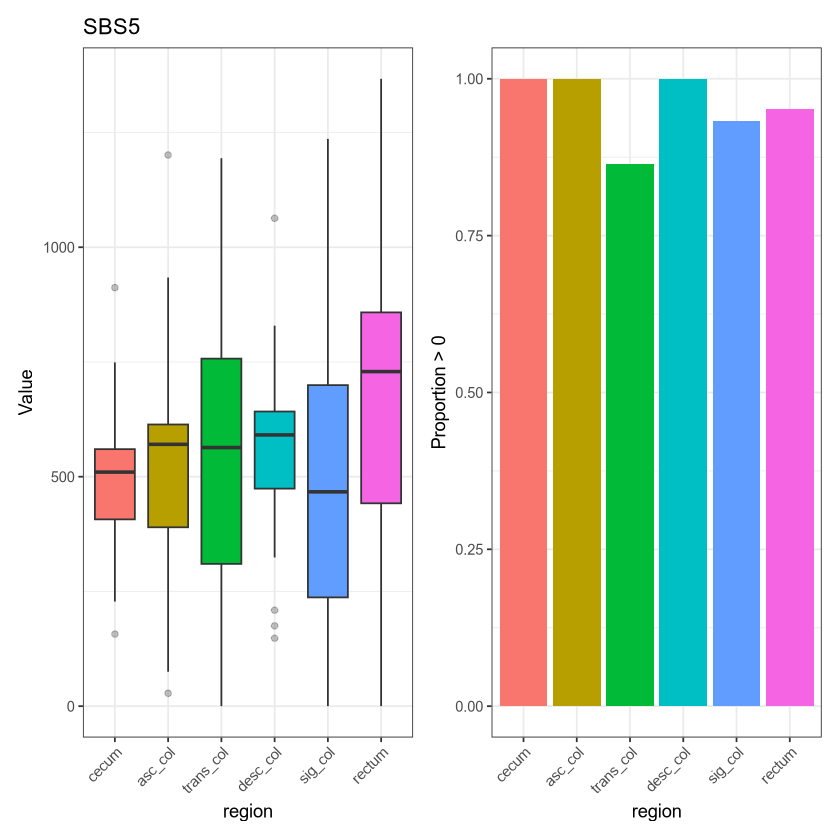

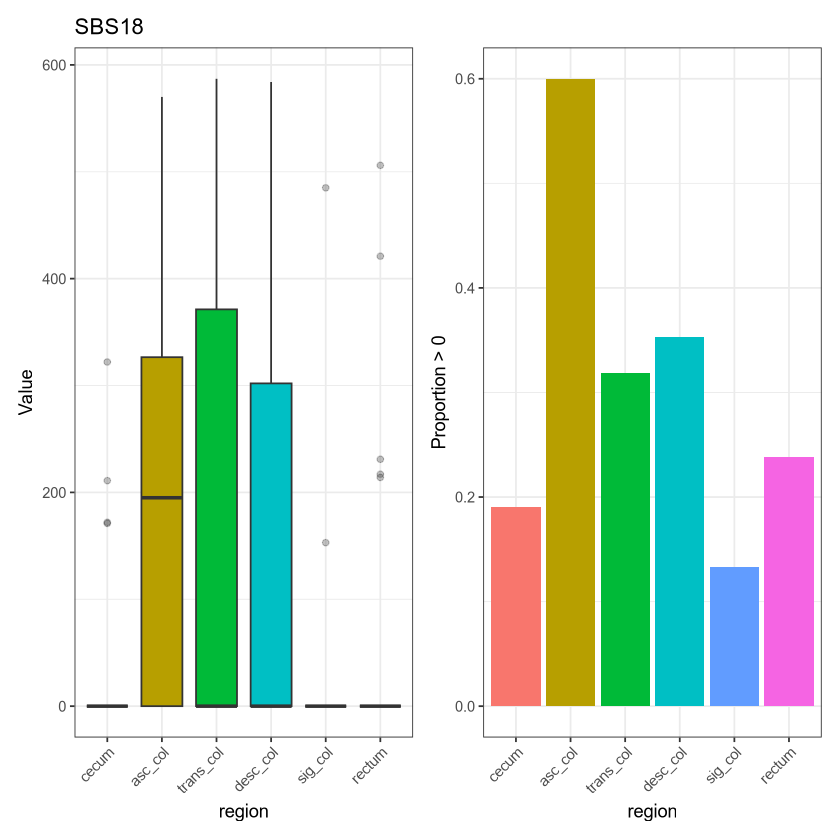

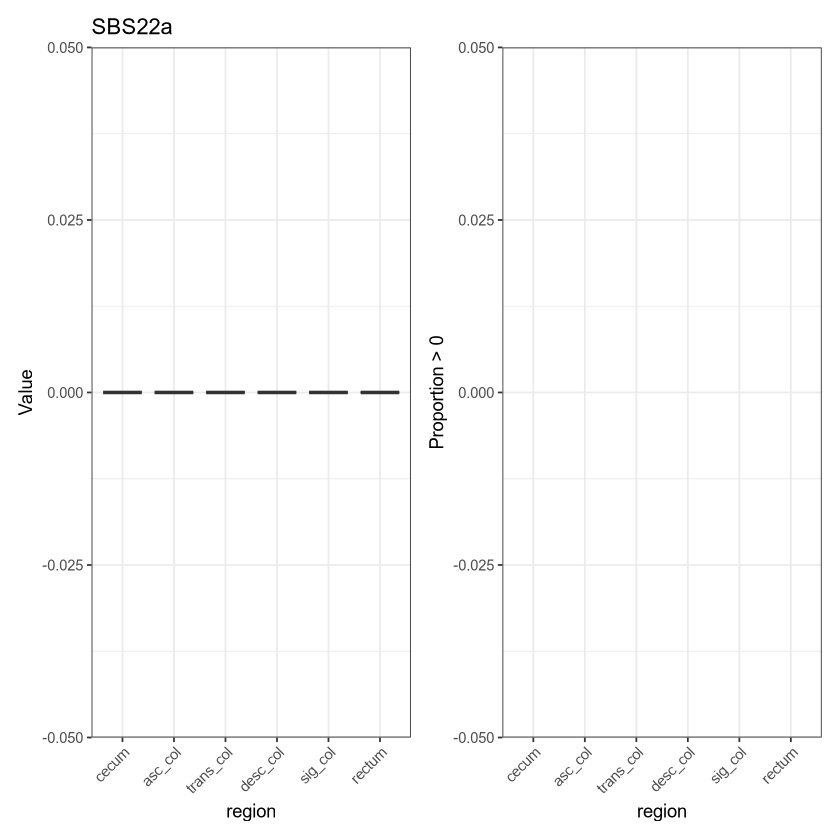

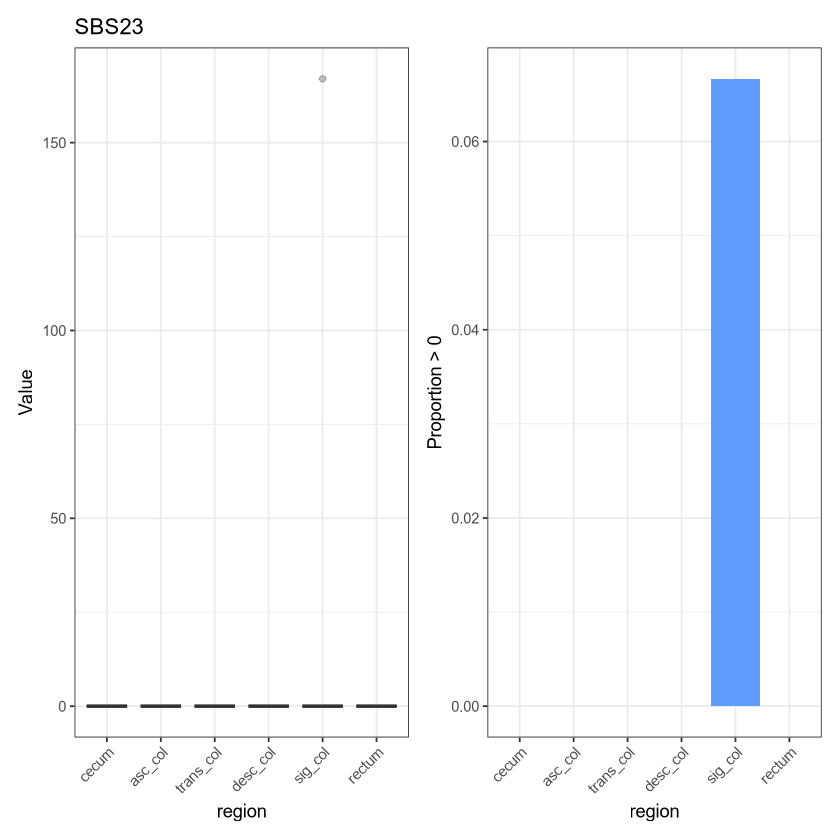

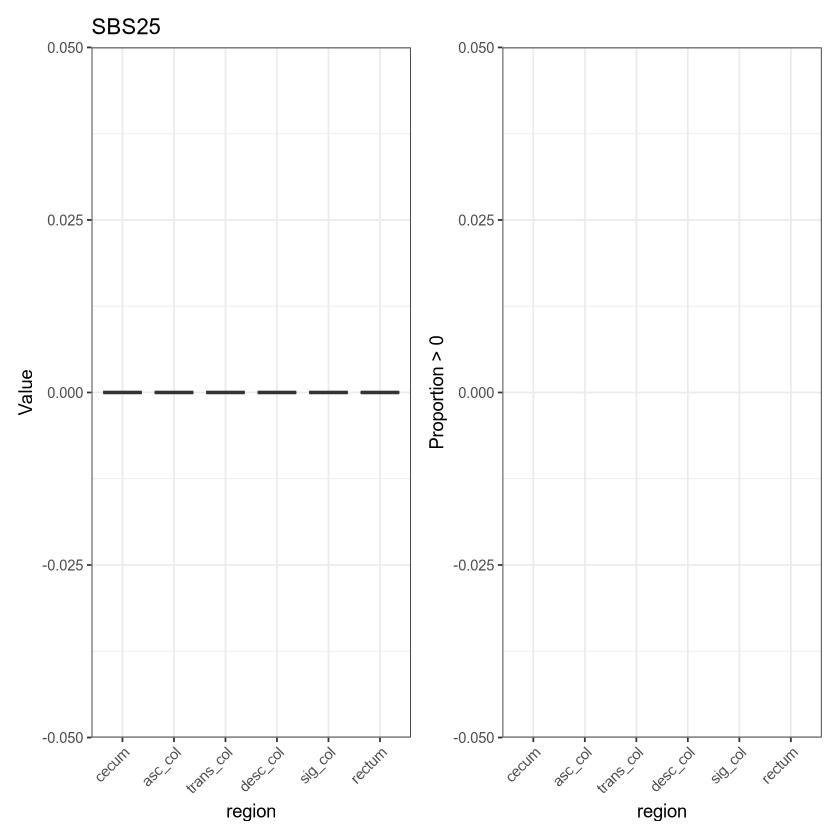

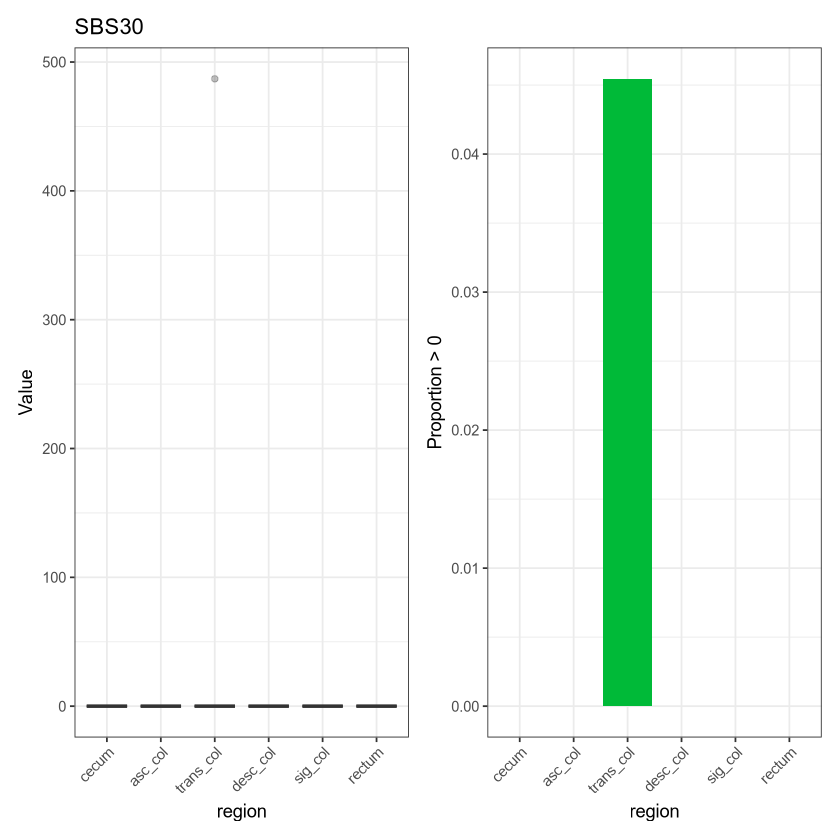

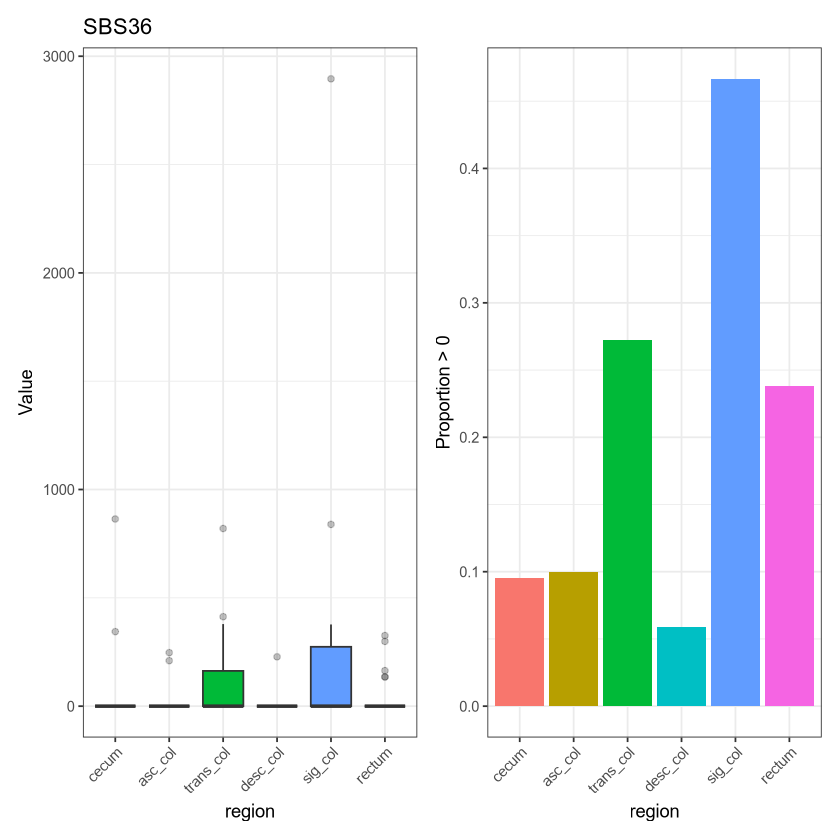

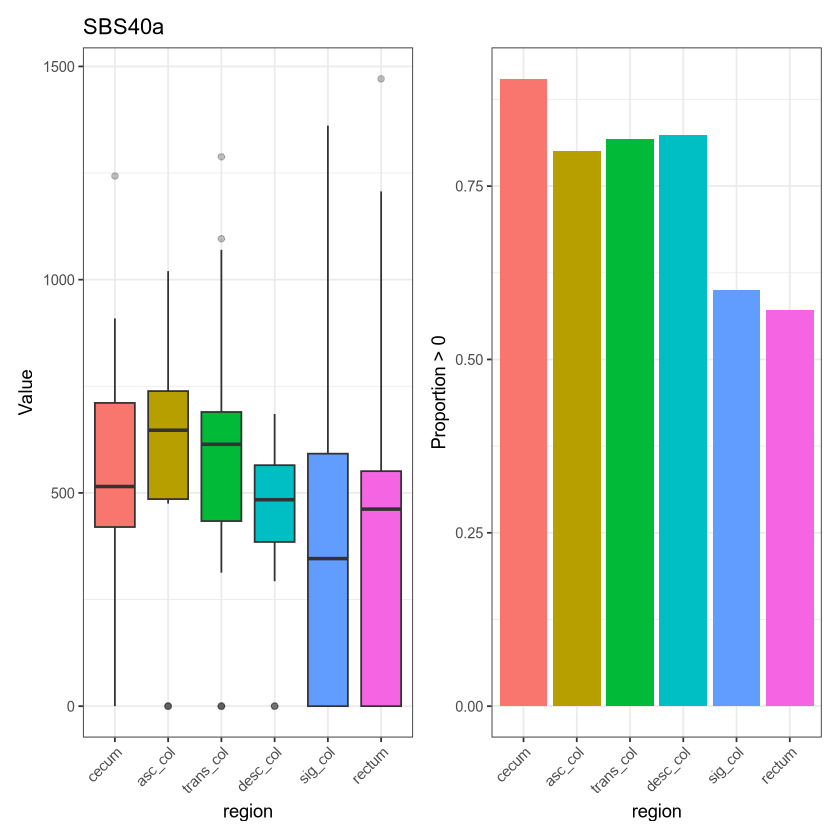

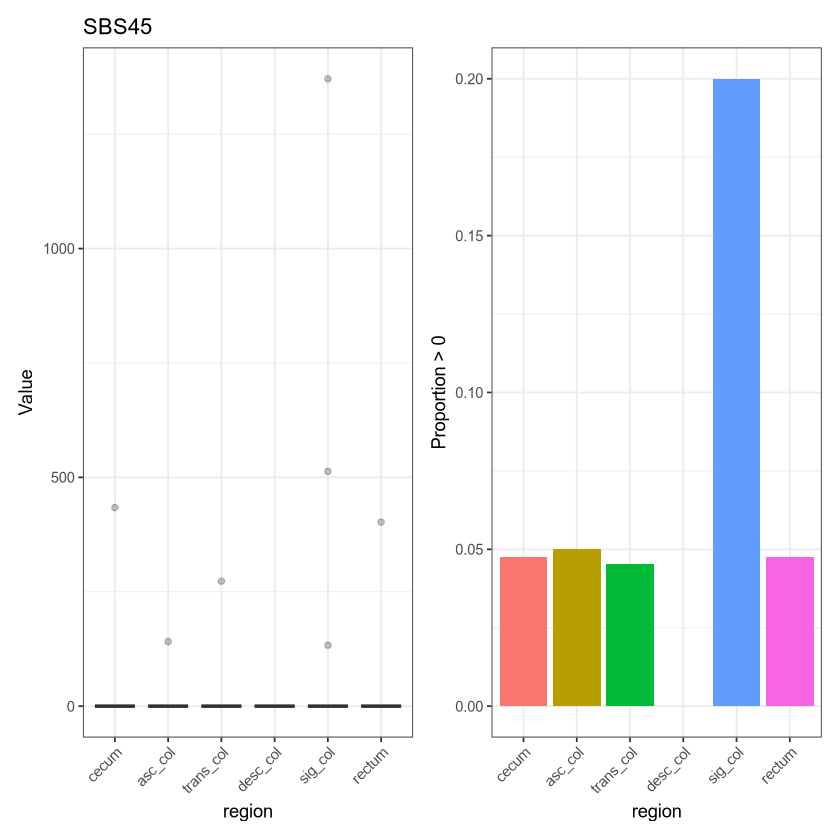

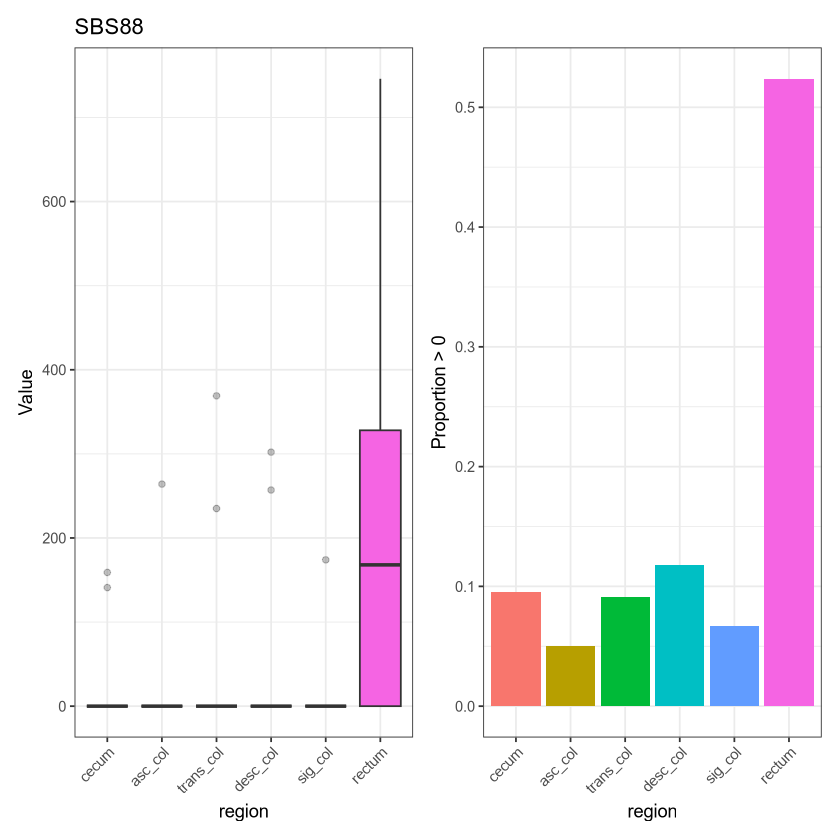

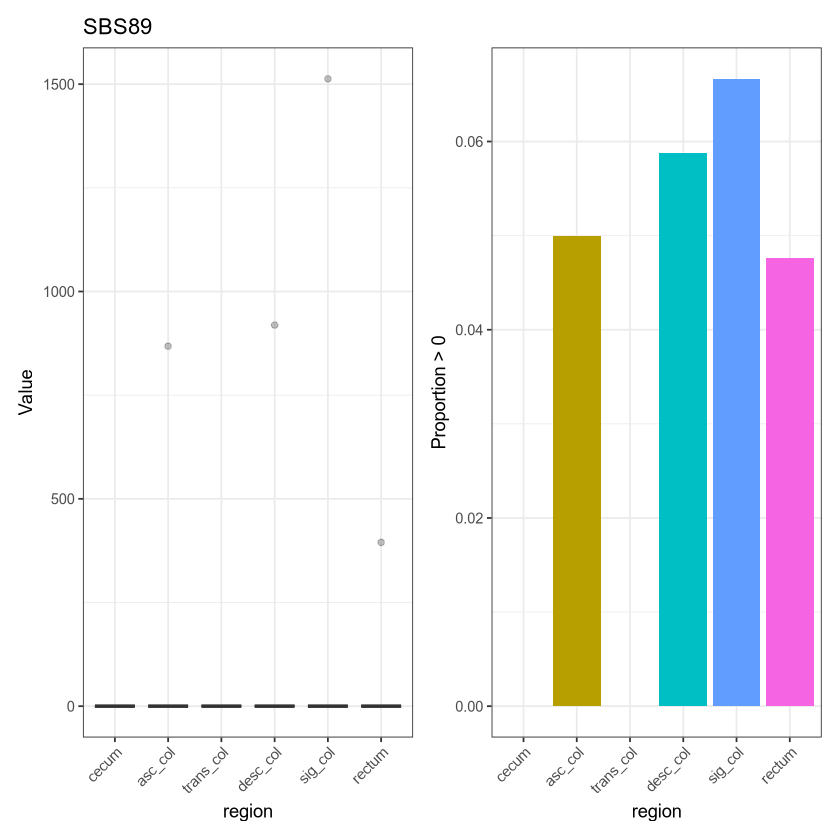

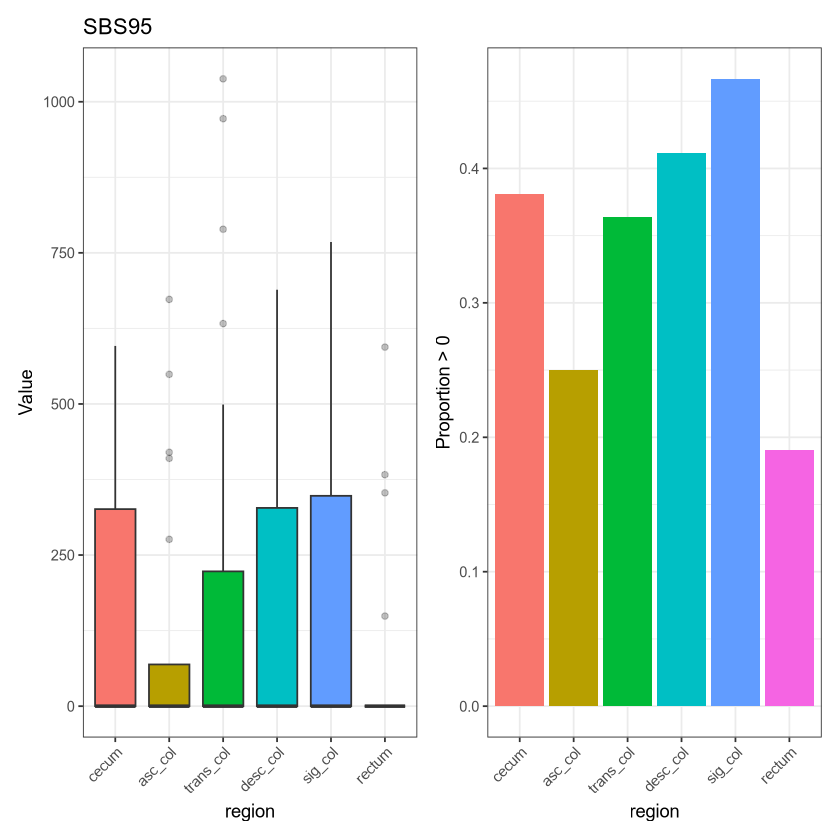

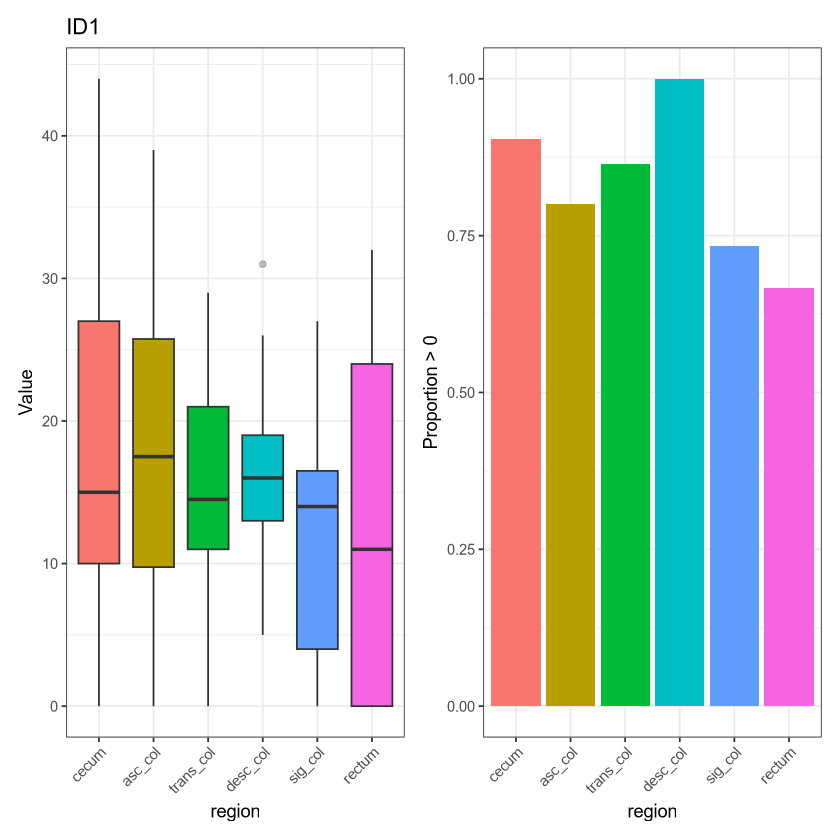

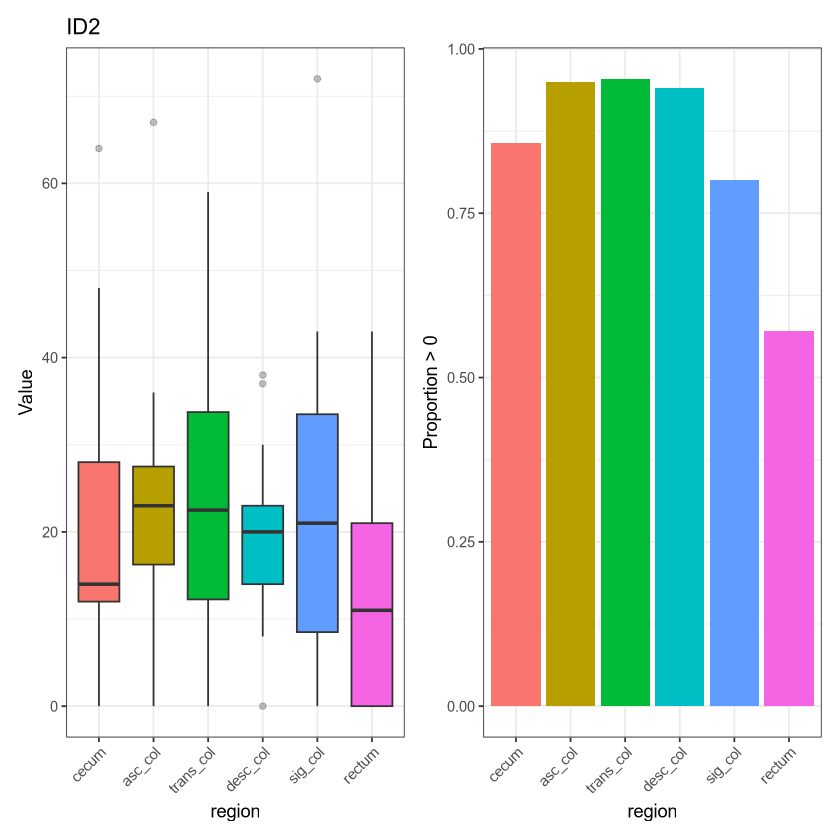

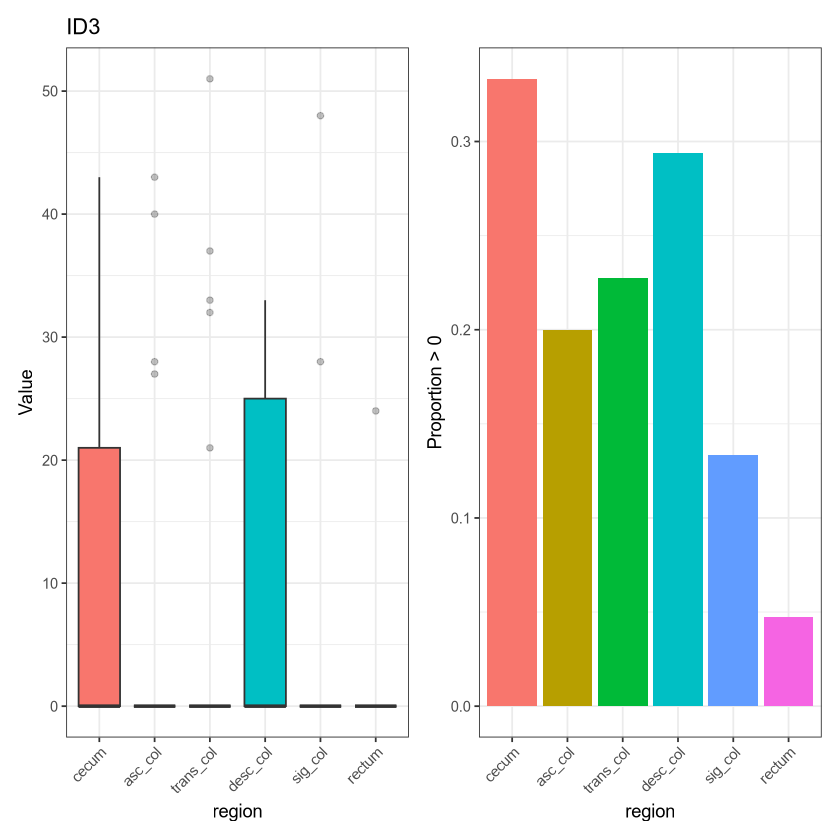

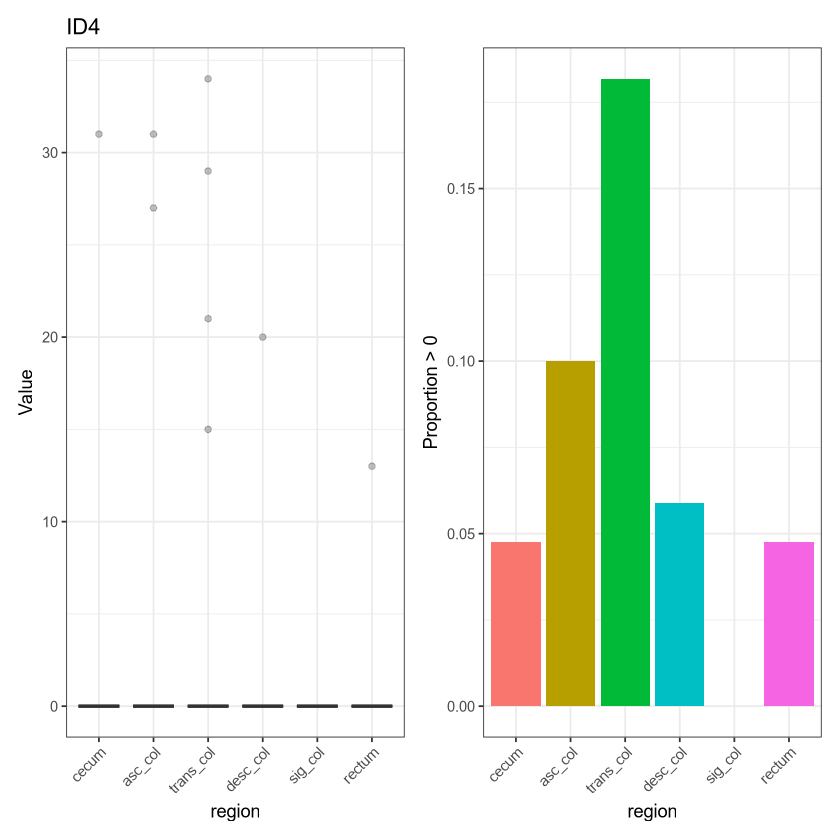

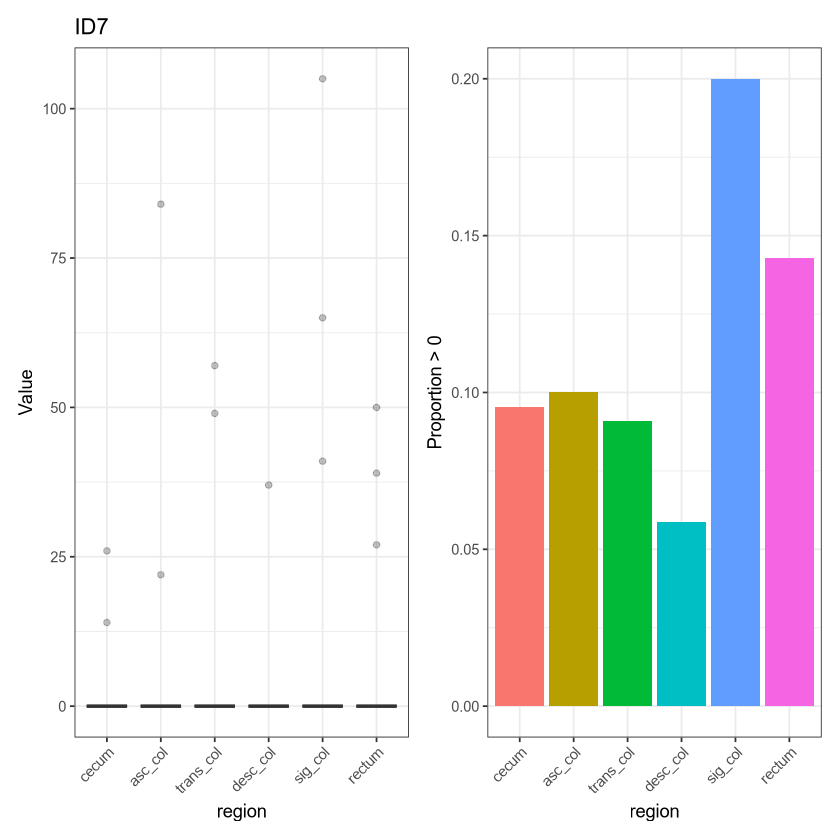

NULL

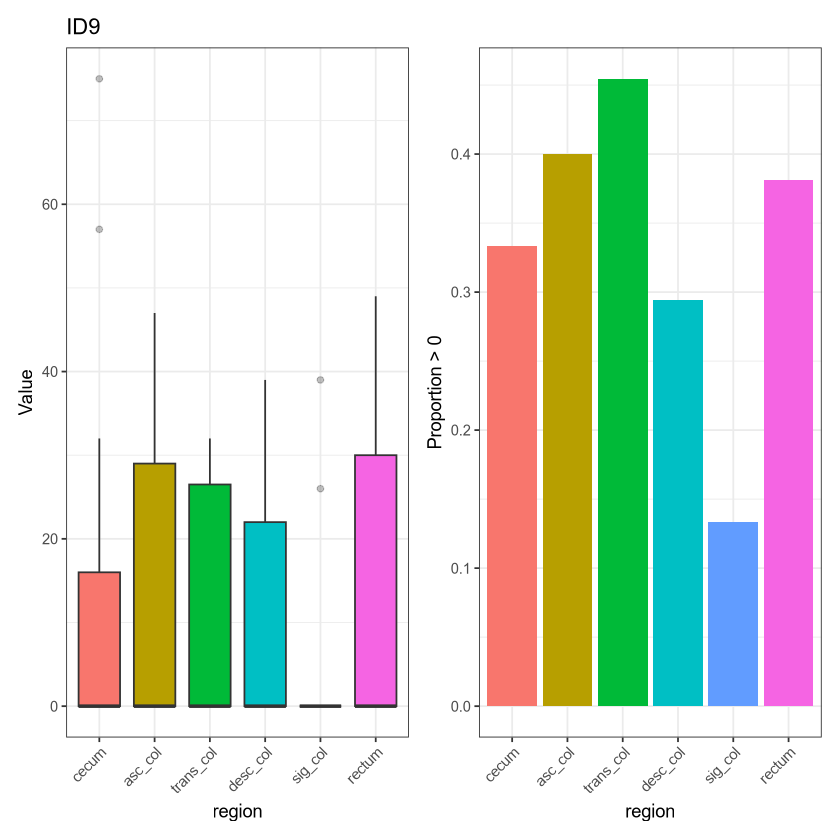

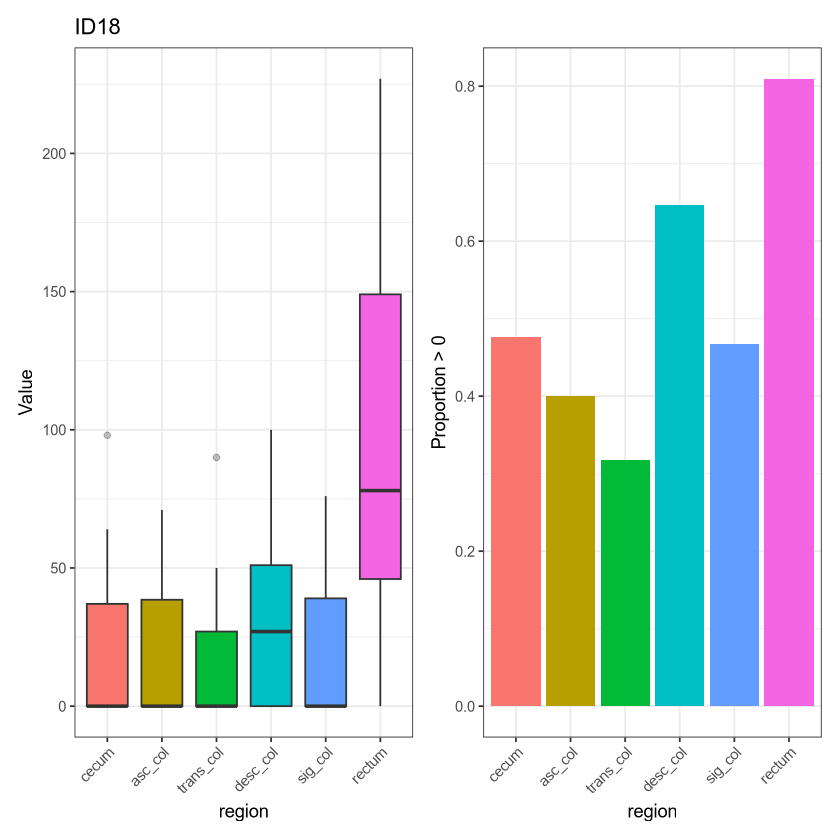

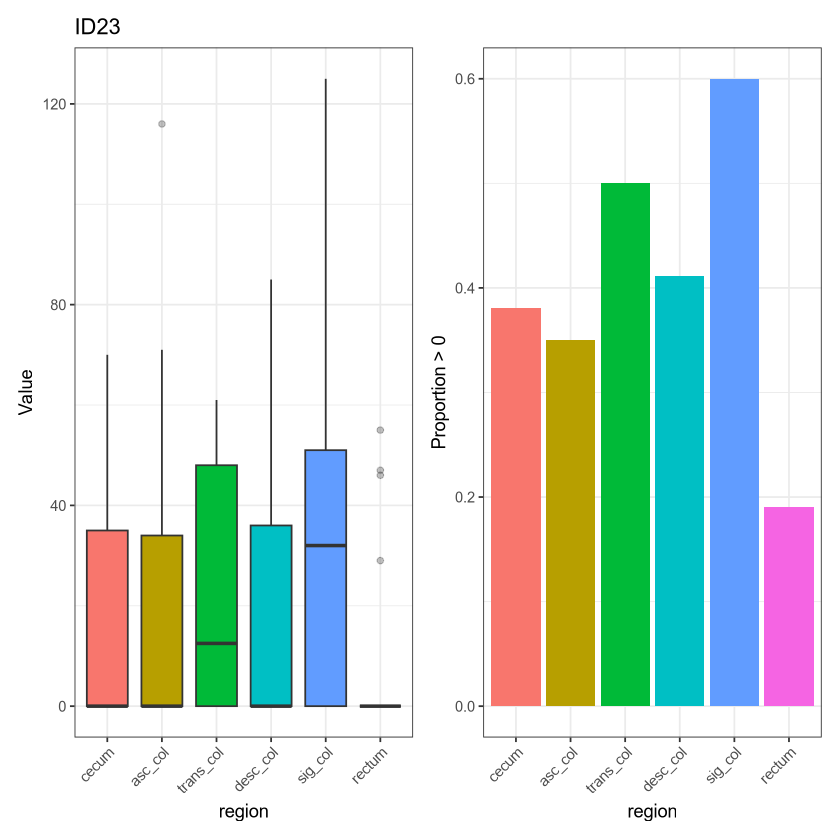

In [ ]:
sig_long <- Hiatt %>%
  pivot_longer(cols = all_of(sig_cols),
               names_to = "signature",
               values_to = "value")

# 3. Split list: one data frame per signature
sig_list <- split(sig_long, sig_long$signature)

# 4. Function to generate one combined plot for a given signature
make_sig_plot <- function(df) {

  sig_name <- unique(df$signature)

  # barplot data
  prop_df <- df %>%
    mutate(has_signature = value > 0) %>%
    group_by(region) %>%
    summarize(prop = mean(has_signature), .groups = "drop")

  # boxplot
  p_box <- ggplot(df, aes(x = region, y = value, fill = region)) +
    geom_boxplot(outlier.alpha = 0.3) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Value") +
    ggtitle(sig_name)

  # barplot
  p_bar <- ggplot(prop_df, aes(x = region, y = prop, fill = region)) +
    geom_col() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylab("Proportion > 0")

  # combine (boxplot | barplot)
  p_box | p_bar
}

# 5. Create the list of plots — one per signature
signature_plots <- lapply(sig_list, make_sig_plot)

# Now you can view one signature per page:
signature_plots[["SBS1"]]
signature_plots[["SBS5"]]
signature_plots[["SBS18"]]
signature_plots[["SBS22a"]]
signature_plots[["SBS23"]]
signature_plots[["SBS25"]]
signature_plots[["SBS30"]]
signature_plots[["SBS36"]]
signature_plots[["SBS40a"]]
signature_plots[["SBS45"]]
signature_plots[["SBS88"]]
signature_plots[["SBS89"]]
signature_plots[["SBS95"]]
signature_plots[["ID1"]]
signature_plots[["ID2"]]
signature_plots[["ID3"]]
signature_plots[["ID4"]]
signature_plots[["ID7"]]
signature_plots[["ID9"]]
signature_plots[["ID18"]]
signature_plots[["ID23"]]

SBS1 SBS5 plot?

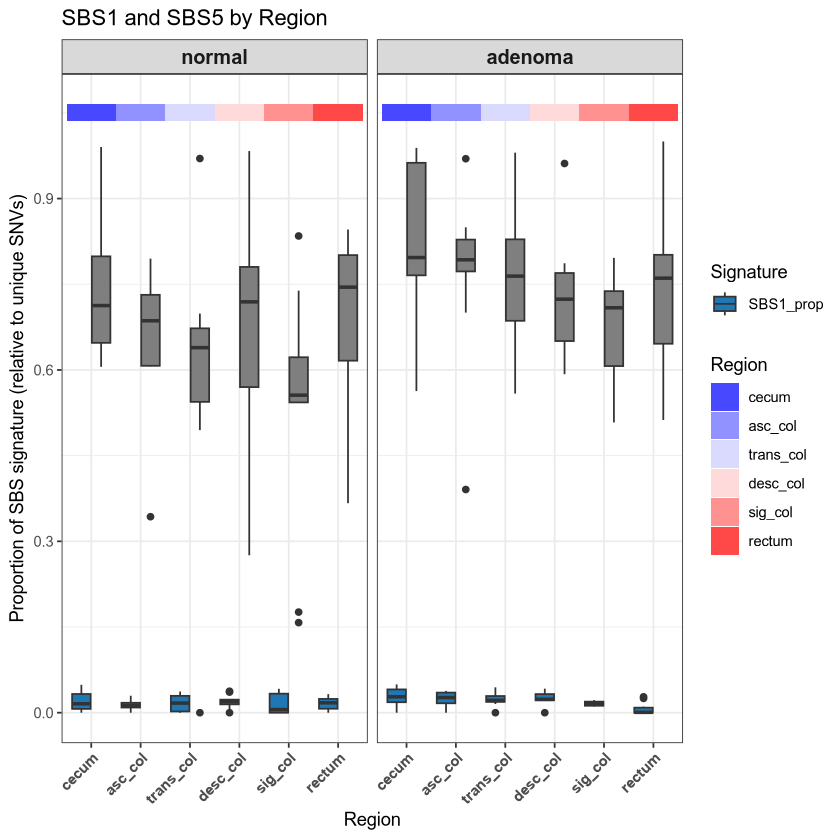

In [30]:
Hiatt$SBS1_prop <- Hiatt$SBS1 / Hiatt$unique_SNVs
Hiatt$SBS5_40_prop <- (Hiatt$SBS5 + Hiatt$SBS40a) / Hiatt$unique_SNVs
make_boxplot_sbs1_sbs5_with_strip <- function(df, region_order, title) {

  # 1. Pivot to long format using precomputed proportions
  df_long <- df %>%
    select(crypt_sample, region, cohort, SBS1_prop, SBS5_40_prop) %>%
    pivot_longer(cols = c(SBS1_prop, SBS5_40_prop),
                 names_to = "signature",
                 values_to = "prop") %>%
    mutate(region = factor(region, levels = region_order),
           xid = paste(cohort, region, crypt_sample, sep = "_"))

  # 2. Region strip (gradient) - one row per sample
  region_strip <- df_long %>%
    select(xid, region, cohort) %>%
    distinct() %>%
    mutate(y = 1.05)  # y position for the strip

  # 3. Colors
  sig_colors <- c("SBS1_prop" = "#1f78b4", "SBS5_prop" = "#33a02c")
  region_colors <- colorRampPalette(c("blue", "white", "red"))(length(region_order))
  names(region_colors) <- region_order

  # 4. Plot
  ggplot() +
    # boxplots
    geom_boxplot(data = df_long,
                 aes(x = region, y = prop, fill = signature),
                 position = position_dodge(width = 0.8)) +
    scale_fill_manual(values = sig_colors, name = "Signature") +
    # new fill scale for region strip
    ggnewscale::new_scale_fill() +
    geom_tile(data = region_strip,
              aes(x = region, y = y, fill = region),
              height = 0.03) +
    scale_fill_manual(values = region_colors, name = "Region") +
    facet_wrap(~ cohort, scales = "free_x") +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
      strip.text = element_text(size = 12, face = "bold")
    ) +
    ylab("Proportion of SBS signature (relative to unique SNVs)") +
    xlab("Region") +
    ggtitle(title)
}

make_boxplot_sbs1_sbs5_with_strip(Hiatt, region_order, title = "SBS1 and SBS5 by Region")



`geom_smooth()` using formula = 'y ~ x'


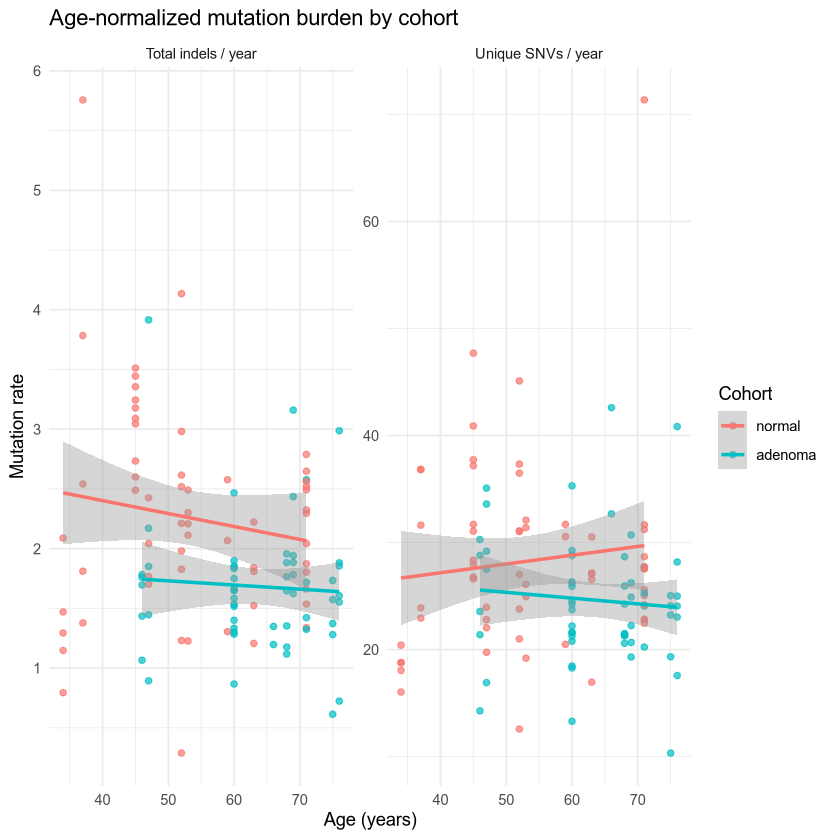

In [31]:
Hiatt_rates <- Hiatt %>%
  mutate(
    SNVs_per_year   = unique_SNVs / age,
    indels_per_year = total_indels / age
  )

  Hiatt_rates_long <- Hiatt_rates %>%
  pivot_longer(
    cols = c(SNVs_per_year, indels_per_year),
    names_to = "metric",
    values_to = "rate"
  ) %>%
  mutate(
    metric = recode(
      metric,
      SNVs_per_year   = "Unique SNVs / year",
      indels_per_year = "Total indels / year"
    )
  )

ggplot(Hiatt_rates_long,
       aes(x = age, y = rate, color = cohort)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = TRUE) +
  facet_wrap(~ metric, scales = "free_y") +
  theme_minimal() +
  labs(
    x = "Age (years)",
    y = "Mutation rate",
    color = "Cohort",
    title = "Age-normalized mutation burden by cohort"
  )


In [61]:
mut_types <- c("C.T", "T.C", "C.A", "T.A", "C.G", "T.G", "CpG")

Hiatt_long <- Hiatt %>%
  select(region, side, all_of(mut_types), donor) %>%
  pivot_longer(
    cols = all_of(mut_types),
    names_to = "mutation_type",
    values_to = "count"
  )

In [62]:
Hiatt_long <- Hiatt_long %>%
  group_by(region, side) %>%
  mutate(prop = count / sum(count, na.rm = TRUE)) %>%
  ungroup()


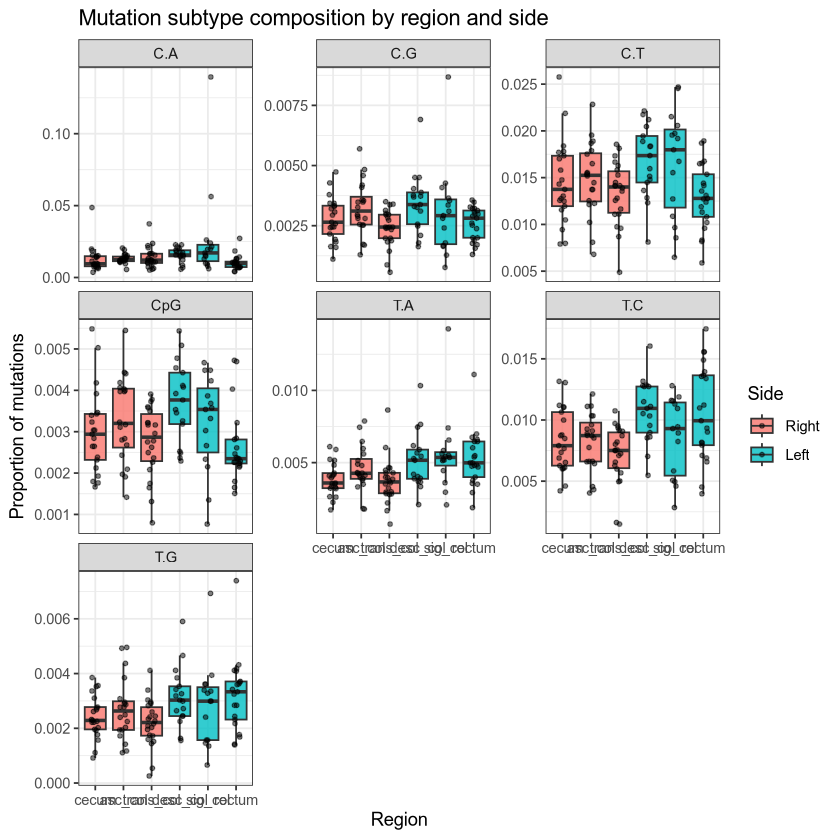

In [63]:
ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.8) +
  geom_jitter(width = 0.15, alpha = 0.5, size = 1) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw() +
  labs(
    x = "Region",
    y = "Proportion of mutations",
    fill = "Side",
    title = "Mutation subtype composition by region and side"
  )


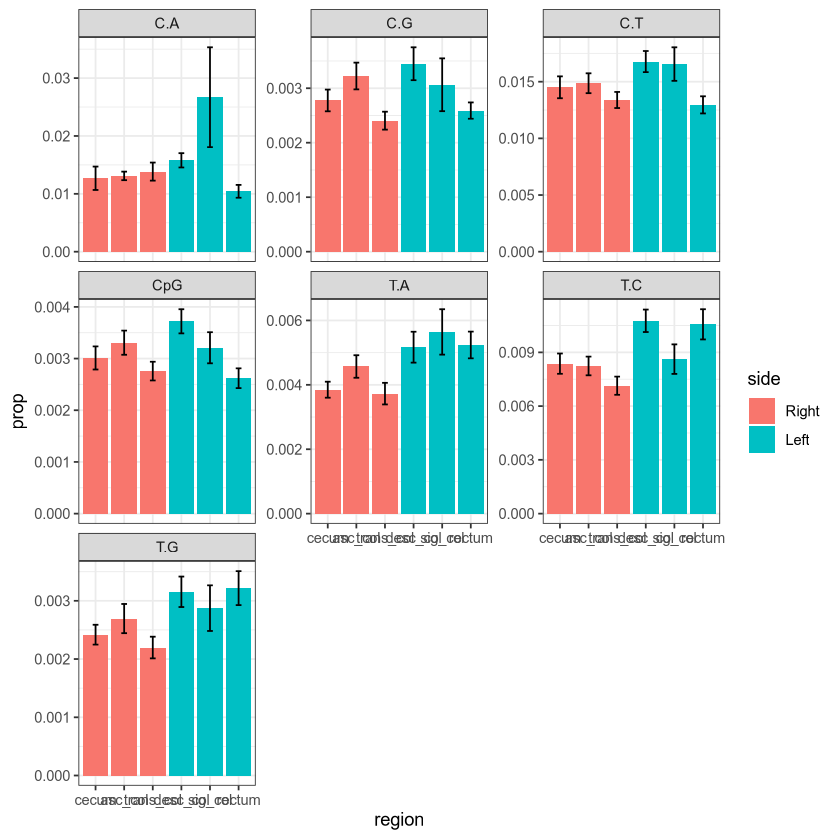

In [64]:
ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  stat_summary(fun = mean, geom = "col", position = "dodge") +
  stat_summary(fun.data = mean_se, geom = "errorbar",
               position = position_dodge(width = 0.9), width = 0.2) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw()


In [65]:
library(broom)

stats_results <- Hiatt_long %>%
  group_by(mutation_type) %>%
  do(
    broom::tidy(
      lm(prop ~ region * side, data = .)
    )
  ) %>%
  ungroup()


In [66]:
stats_results <- stats_results %>%
  group_by(term) %>%
  mutate(p_adj = p.adjust(p.value, method = "BH")) %>%
  ungroup()


In [67]:
stats_summary <- stats_results %>%
  filter(term != "(Intercept)") %>%
  select(
    mutation_type,
    term,
    estimate,
    p.value,
    p_adj
  ) %>%
  arrange(mutation_type, term)


In [ ]:
wilcox_side <- Hiatt_long %>%
  filter(side %in% c("Right", "Left")) %>%

  # 1. collapse multiple crypts per donor × side
  group_by(mutation_type, donor, side) %>%
  summarise(
    prop_mean = mean(prop, na.rm = TRUE),
    .groups = "drop"
  ) %>%

  # 2. keep only true donor pairs
  group_by(mutation_type, donor) %>%
  filter(n_distinct(side) == 2) %>%

  # 3. reshape to paired columns
  summarise(
    Right = prop_mean[side == "Right"],
    Left  = prop_mean[side == "Left"],
    .groups = "drop"
  ) %>%

  # 4. paired Wilcoxon per mutation subtype
  group_by(mutation_type) %>%
  summarise(
    p_value = wilcox.test(Right, Left, paired = TRUE, exact = FALSE)$p.value,
    .groups = "drop"
  ) %>%

  mutate(
    p_adj = p.adjust(p_value, method = "BH"),
    sig = case_when(
      p_adj < 0.001 ~ "***",
      p_adj < 0.01  ~ "**",
      p_adj < 0.05  ~ "*",
      TRUE          ~ "ns"
    )
  )


In [84]:
effect_size <- Hiatt_long %>%
  group_by(mutation_type, donor, side) %>%
  summarise(prop_mean = mean(prop), .groups = "drop") %>%
  pivot_wider(names_from = side, values_from = prop_mean) %>%
  mutate(delta = Right - Left) %>%
  group_by(mutation_type) %>%
  summarise(
    median_delta = median(delta, na.rm = TRUE),
    .groups = "drop"
  )


In [74]:
lm_region <- Hiatt_long %>%
  group_by(mutation_type) %>%
  do(
    broom::tidy(lm(prop ~ region, data = .))
  ) %>%
  filter(term != "(Intercept)") %>%
  ungroup() %>%
  mutate(
    p_adj = p.adjust(p.value, method = "BH"),
    sig = case_when(
      p_adj < 0.001 ~ "***",
      p_adj < 0.01  ~ "**",
      p_adj < 0.05  ~ "*",
      TRUE          ~ ""
    )
  )



In [86]:
annot_side <- Hiatt_long %>%
  group_by(mutation_type) %>%
  summarise(
    x = first(region),                       # anchor inside facet
    y = max(prop, na.rm = TRUE) * 1.25,      # above boxes
    .groups = "drop"
  ) %>%
  left_join(wilcox_side, by = "mutation_type")


In [87]:
annot_side

mutation_type,x,y,p_value,p_adj,sig
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>
C.A,desc_col,0.174325310,0.1977539338,0.197753934,ns
C.G,desc_col,0.010849745,0.0499998630,0.058333174,ns
C.T,desc_col,0.032206185,0.0084895554,0.014856722,*
CpG,desc_col,0.006857591,0.0177580610,0.024861285,*
T.A,desc_col,0.017824581,0.0004188114,0.001465840,**
T.C,desc_col,0.021812226,0.0002727066,0.001465840,**
T.G,desc_col,0.009239398,0.0006356242,0.001483123,**


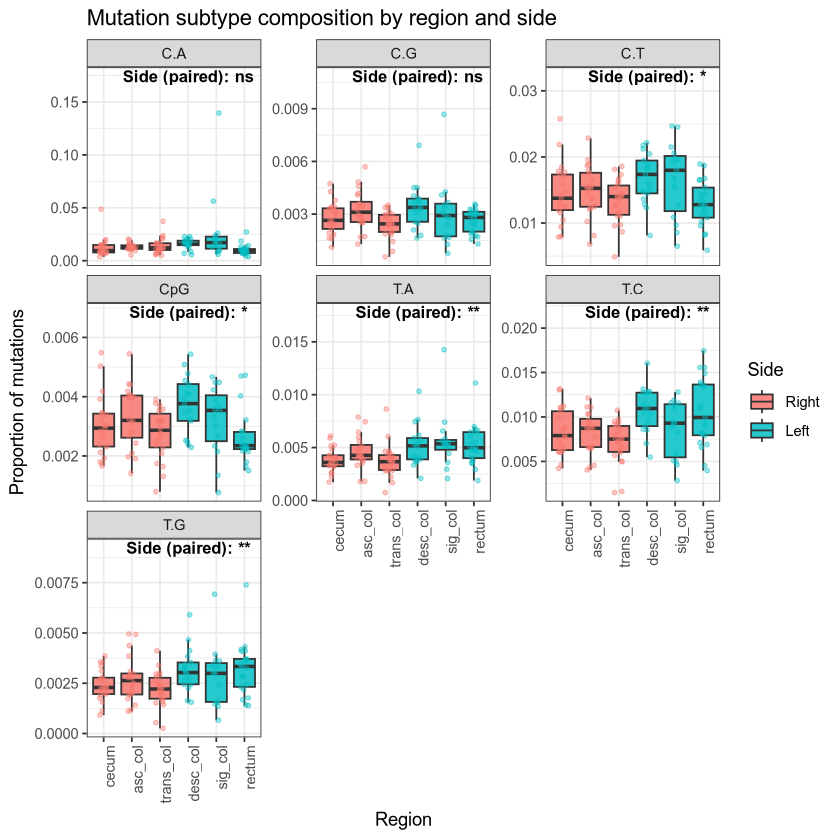

In [ ]:
ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.85) +
  geom_jitter(
    aes(color = side),
    width = 0.15,
    alpha = 0.4,
    size = 1,
    show.legend = FALSE
  ) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) +

  ## ---- paired Wilcoxon annotation ----
  geom_text(
    data = annot_side,
    aes(x = x, y = y, label = paste0("Side (paired): ", sig)),
    inherit.aes = FALSE,
    size = 3.5,
    fontface = "bold"
  ) +

  labs(
    x = "Region",
    y = "Proportion of mutations",
    fill = "Side",
    title = "Mutation subtype composition by region and side"
  )


In [90]:
mut_types <- c("C.T", "T.C", "C.A", "T.A", "C.G", "T.G", "CpG")

Hiatt_long <- combined_df %>%
  select(region, side, all_of(mut_types), donor) %>%
  pivot_longer(
    cols = all_of(mut_types),
    names_to = "mutation_type",
    values_to = "count"
  )


Hiatt_long <- Hiatt_long %>%
  group_by(region, side) %>%
  mutate(prop = count / sum(count, na.rm = TRUE)) %>%
  ungroup()


wilcox_side <- Hiatt_long %>%
  filter(side %in% c("Right", "Left")) %>%

  # 1. collapse multiple crypts per donor × side
  group_by(mutation_type, donor, side) %>%
  summarise(
    prop_mean = mean(prop, na.rm = TRUE),
    .groups = "drop"
  ) %>%

  # 2. keep only true donor pairs
  group_by(mutation_type, donor) %>%
  filter(n_distinct(side) == 2) %>%

  # 3. reshape to paired columns
  summarise(
    Right = prop_mean[side == "Right"],
    Left  = prop_mean[side == "Left"],
    .groups = "drop"
  ) %>%

  # 4. paired Wilcoxon per mutation subtype
  group_by(mutation_type) %>%
  summarise(
    p_value = wilcox.test(Right, Left, paired = TRUE, exact = FALSE)$p.value,
    .groups = "drop"
  ) %>%

  mutate(
    p_adj = p.adjust(p_value, method = "BH"),
    sig = case_when(
      p_adj < 0.001 ~ "***",
      p_adj < 0.01  ~ "**",
      p_adj < 0.05  ~ "*",
      TRUE          ~ "ns"
    )
  )


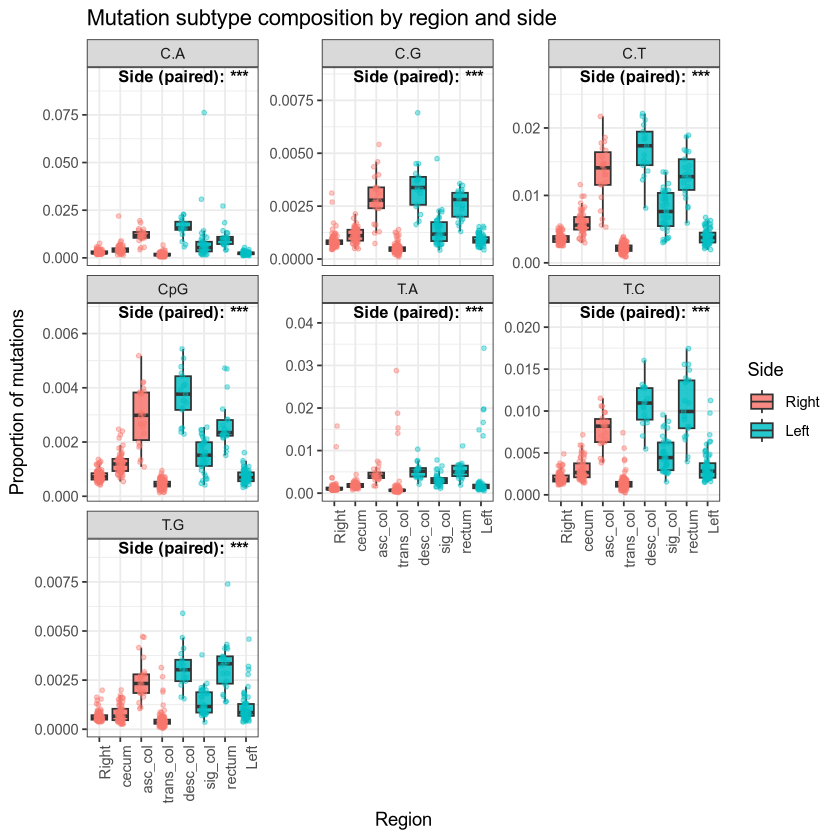

In [94]:
annot_side <- Hiatt_long %>%
  group_by(mutation_type) %>%
  summarise(
    x = first(region),                       # anchor inside facet
    y = max(prop, na.rm = TRUE) * 1.25,      # above boxes
    .groups = "drop"
  ) %>%
  left_join(wilcox_side, by = "mutation_type")


ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.85) +
  geom_jitter(
    aes(color = side),
    width = 0.15,
    alpha = 0.4,
    size = 1,
    show.legend = FALSE
  ) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) +

  ## ---- paired Wilcoxon annotation ----
  geom_text(
    data = annot_side,
    aes(x = x, y = y, label = paste0("Side (paired): ", sig)),
    inherit.aes = FALSE,
    size = 3.5,
    fontface = "bold"
  ) +

  labs(
    x = "Region",
    y = "Proportion of mutations",
    fill = "Side",
    title = "Mutation subtype composition by region and side"
  )


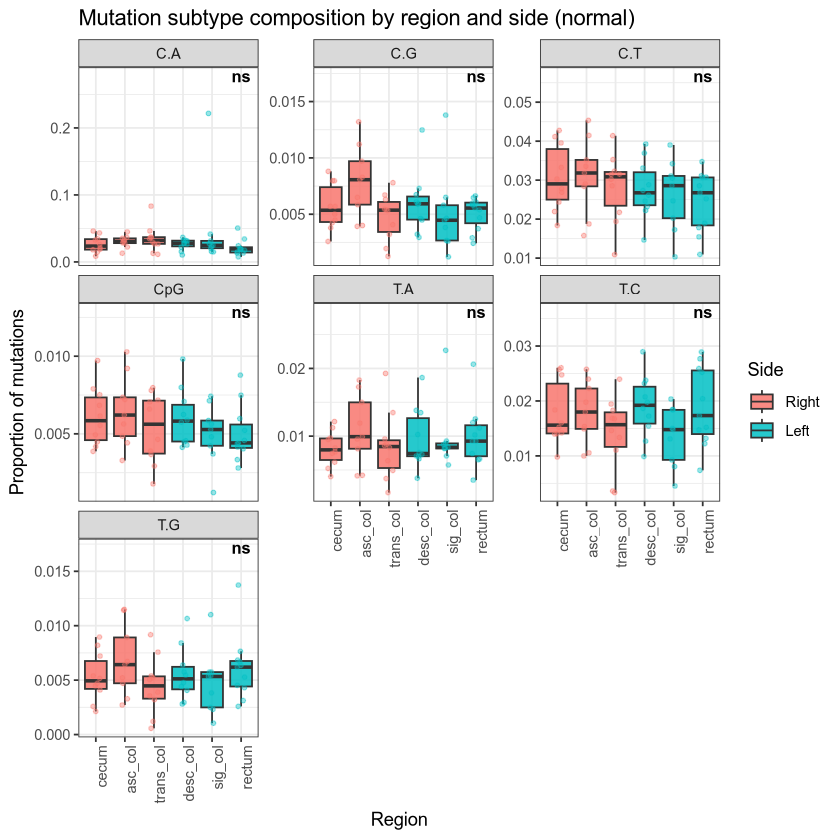

In [5]:
mut_types <- c("C.T", "T.C", "C.A", "T.A", "C.G", "T.G", "CpG")

Hiatt_long <- subset(Hiatt, cohort == "normal") %>%
  select(region, side, all_of(mut_types), donor) %>%
  pivot_longer(
    cols = all_of(mut_types),
    names_to = "mutation_type",
    values_to = "count"
  )


Hiatt_long <- Hiatt_long %>%
  group_by(region, side) %>%
  mutate(prop = count / sum(count, na.rm = TRUE)) %>%
  ungroup()


wilcox_side <- Hiatt_long %>%
  filter(side %in% c("Right", "Left")) %>%

  # 1. collapse multiple crypts per donor × side
  group_by(mutation_type, donor, side) %>%
  summarise(
    prop_mean = mean(prop, na.rm = TRUE),
    .groups = "drop"
  ) %>%

  # 2. keep only true donor pairs
  group_by(mutation_type, donor) %>%
  filter(n_distinct(side) == 2) %>%

  # 3. reshape to paired columns
  summarise(
    Right = prop_mean[side == "Right"],
    Left  = prop_mean[side == "Left"],
    .groups = "drop"
  ) %>%

  # 4. paired Wilcoxon per mutation subtype
  group_by(mutation_type) %>%
  summarise(
    p_value = wilcox.test(Right, Left, paired = TRUE, exact = FALSE)$p.value,
    .groups = "drop"
  ) %>%

  mutate(
    p_adj = p.adjust(p_value, method = "BH"),
    sig = case_when(
      p_adj < 0.001 ~ "***",
      p_adj < 0.01  ~ "**",
      p_adj < 0.05  ~ "*",
      TRUE          ~ "ns"
    )
  )

annot_side <- Hiatt_long %>%
  group_by(mutation_type) %>%
  summarise(
    x = first(region),                       # anchor inside facet
    y = max(prop, na.rm = TRUE) * 1.25,      # above boxes
    .groups = "drop"
  ) %>%
  left_join(wilcox_side, by = "mutation_type")


ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.85) +
  geom_jitter(
    aes(color = side),
    width = 0.15,
    alpha = 0.4,
    size = 1,
    show.legend = FALSE
  ) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) +

  ## ---- paired Wilcoxon annotation ----
  geom_text(
    data = annot_side,
    aes(x = x, y = y, label = paste0(sig)),
    inherit.aes = FALSE,
    size = 3.5,
    fontface = "bold"
  ) +

  labs(
    x = "Region",
    y = "Proportion of mutations",
    fill = "Side",
    title = "Mutation subtype composition by region and side (normal)"
  )


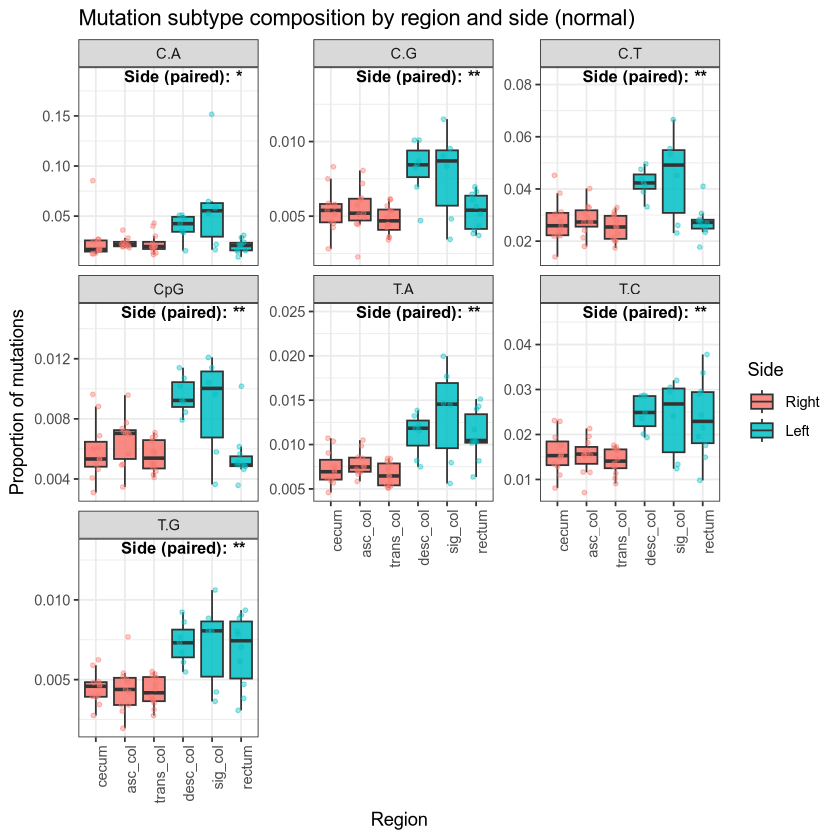

In [3]:
mut_types <- c("C.T", "T.C", "C.A", "T.A", "C.G", "T.G", "CpG")

Hiatt_long <- subset(Hiatt, cohort == "adenoma") %>%
  select(region, side, all_of(mut_types), donor) %>%
  pivot_longer(
    cols = all_of(mut_types),
    names_to = "mutation_type",
    values_to = "count"
  )


Hiatt_long <- Hiatt_long %>%
  group_by(region, side) %>%
  mutate(prop = count / sum(count, na.rm = TRUE)) %>%
  ungroup()


wilcox_side <- Hiatt_long %>%
  filter(side %in% c("Right", "Left")) %>%

  # 1. collapse multiple crypts per donor × side
  group_by(mutation_type, donor, side) %>%
  summarise(
    prop_mean = mean(prop, na.rm = TRUE),
    .groups = "drop"
  ) %>%

  # 2. keep only true donor pairs
  group_by(mutation_type, donor) %>%
  filter(n_distinct(side) == 2) %>%

  # 3. reshape to paired columns
  summarise(
    Right = prop_mean[side == "Right"],
    Left  = prop_mean[side == "Left"],
    .groups = "drop"
  ) %>%

  # 4. paired Wilcoxon per mutation subtype
  group_by(mutation_type) %>%
  summarise(
    p_value = wilcox.test(Right, Left, paired = TRUE, exact = FALSE)$p.value,
    .groups = "drop"
  ) %>%

  mutate(
    p_adj = p.adjust(p_value, method = "BH"),
    sig = case_when(
      p_adj < 0.001 ~ "***",
      p_adj < 0.01  ~ "**",
      p_adj < 0.05  ~ "*",
      TRUE          ~ "ns"
    )
  )

annot_side <- Hiatt_long %>%
  group_by(mutation_type) %>%
  summarise(
    x = first(region),                       # anchor inside facet
    y = max(prop, na.rm = TRUE) * 1.25,      # above boxes
    .groups = "drop"
  ) %>%
  left_join(wilcox_side, by = "mutation_type")


ggplot(Hiatt_long,
       aes(x = region, y = prop, fill = side)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.85) +
  geom_jitter(
    aes(color = side),
    width = 0.15,
    alpha = 0.4,
    size = 1,
    show.legend = FALSE
  ) +
  facet_wrap(~ mutation_type, scales = "free_y") +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) +

  ## ---- paired Wilcoxon annotation ----
  geom_text(
    data = annot_side,
    aes(x = x, y = y, label = paste0("Side (paired): ", sig)),
    inherit.aes = FALSE,
    size = 3.5,
    fontface = "bold"
  ) +

  labs(
    x = "Region",
    y = "Proportion of mutations",
    fill = "Side",
    title = "Mutation subtype composition by region and side (normal)"
  )
